In [981]:
import numpy as np
import numpy.matlib
import math
from scipy.optimize import fsolve

# for testing
datasize_x = 255
datasize_y = 255

# parameters
L = 0.5  # Length (before strain)
N = 50  # Spatial resolution
E = 207e9  # Young's modulus
r = 0.001  # Cross-section radius
rt1 = np.mat([[0.02], [0], [0]])
rt2 = np.mat([[-0.02], [0], [0]])
rho = 8000  # Density
g = np.mat([[-9.81], [0], [0]])  # Gravity
Bse = np.matlib.zeros(3)  # Material damping coefficients - shear and extension
Bbt = 1e-2 * np.eye(3)  # Material damping coefficients - bending and torsion
C = 0.1 * np.eye(3)
dt = 0.04  # Time step
alpha = -0.2  # BDF-alpha parameter
STEPS = 202  # Number of timesteps to completion
vstar = np.array([[0], [0], [1]])  # Value of v when static and absent loading
ustar = np.array([[0], [0], [0]])  # Precurvature
vsstar = np.array([[0], [0], [0]])
usstar = np.array([[0], [0], [0]])
    
# Boundary Conditions
p = np.zeros((STEPS, N), dtype=object)
R = np.zeros((STEPS, N), dtype=object)
q = np.zeros((STEPS, N), dtype=object)
w = np.zeros((STEPS, N), dtype=object)
# global p, R, q, w
for i in range(0, STEPS-1):    # from 1 to STEPS
    p[i][0] = np.matlib.zeros((3,1))
    R[i][0] = np.matlib.eye(3)
    q[i][0] = np.matlib.zeros((3,1))
    w[i][0] = np.matlib.zeros((3,1))
    
nL = np.mat([[0], [0], [0]])
mL = np.mat([[0], [0], [0]])

# Dependent Parameter Calculations
A = math.pi*r**2    # Cross-sectional area
J = np.diag([math.pi*r**4/4, math.pi*r**4/4, math.pi*r**4/2])  # Inertia
G = 80e9    # shear modulus
Kse = np.mat(np.diag([G*A, G*A, E*A]))   # Stiffness matrix - shear and extension
Kbt = np.mat(np.diag([E*J[0, 0], E*J[1, 1], G*J[2, 2]]))    # Stiffness matrix - bending and torsion
ds = L/(N-1)    # Grid distance (before strain)
c0 = (1.5 + alpha) / ( dt*(1+alpha) )   # BDF-alpha coefficients
c1 = -2 / dt
c2 = (0.5 + alpha) / (dt * (1 + alpha))
d1 = alpha / (1 + alpha)

n = np.empty([datasize_x,datasize_y], dtype = object)
m = np.empty([datasize_x,datasize_y], dtype = object)

u = np.empty([datasize_x,datasize_y], dtype = object)
uh = np.empty([datasize_x,datasize_y], dtype = object)
us = np.empty([datasize_x,datasize_y], dtype = object)
ush = np.empty([datasize_x,datasize_y], dtype = object)
ust = np.empty([datasize_x,datasize_y], dtype = object)
ut = np.empty([datasize_x,datasize_y], dtype = object)

v = np.empty([datasize_x,datasize_y], dtype = object)
vh = np.empty([datasize_x,datasize_y], dtype = object)
vs = np.empty([datasize_x,datasize_y], dtype = object)
vsh = np.empty([datasize_x,datasize_y], dtype = object)
vst = np.empty([datasize_x,datasize_y], dtype = object)
vt = np.empty([datasize_x,datasize_y], dtype = object)

wh = np.empty([datasize_x,datasize_y], dtype = object)
wt = np.empty([datasize_x,datasize_y], dtype = object)

x = np.empty([datasize_x,datasize_y], dtype = object)
y = np.empty([datasize_x,datasize_y], dtype = object)
z = np.empty([datasize_x,datasize_y], dtype = object)

qh = np.empty([datasize_x,datasize_y], dtype = object)
qt = np.empty([datasize_x,datasize_y], dtype = object)

YY = np.empty([datasize_x,datasize_y], dtype = object)

nLL = np.matlib.zeros((3,1))
mLL = np.matlib.zeros((3,1))

ps, Rs, ns, ms, qs, ws = None, None, None, None, None, None

e = np.matlib.zeros((3,1))
e_dot = np.matlib.zeros((3,1))

In [870]:
def hat(y_in):
    y = np.zeros((3,3))
    y[0][1] = -y_in[2]
    y[0][2] = y_in[1]
    y[1][0] = y_in[2]
    y[1][2] = -y_in[0]
    y[2][0] = y_in[1]
    y[2][1] = y_in[0]
    y = np.mat(y)
    return y

In [1223]:
def find_tension():
    global i, e, e_dot
    t = (i-2)*dt
    
    P_desire = np.mat([[0.25*((1-math.exp(-2*t)))],[0],[0]])
    Pd_desire = np.mat([[0.25*((2*math.exp(-2*t)))],[0],[0]])
    Pdd_desire = np.mat([[0.25*((-4*np.exp(-2*t)))],[0],[0]])
    
#     print("i",i)
#     print("u: \n",u)
#     print("N-1: ", N-1)
#     print("u[0][N-1]: ", u[0][N-2])
    p_dot1 = R[i-1][N-1]*(hat(u[i-1][N-2])*rt1 + v[i-1][N-2])
    p_ddot1 = R[i-1][N-1]*(hat(u[i-1][N-2])*hat(u[i-1][N-2])*rt1 + v[i-1][N-2])+hat(us[i-1][N-2])*rt1 + vs[i-1][N-2]
    alph1 = (hat(p_dot1)*hat(p_dot1)*p_ddot1)/(np.linalg.norm(p_dot1)**3)
    alph11 = (p_dot1)/(np.linalg.norm(p_dot1))
    
    alphM = alph1 + alph11 # mat
    
    ac = (ns + rho*A*g - R[i-1][N-2]*abs(q[i-1][N-2]))/(rho*A)
    bc = -(alphM)/(rho*A)
    
    X_end = p[i-1][N-1]
    Xd_end = R[i-1][N-1]* q[i-1][N-1]
    
    alpa1 = 64.7
    alpa2 = 10
    
    Z1 = P_desire - X_end
    Z2 = Xd_end - Pd_desire - alpa1*Z1
    
#     bc_inv = np.linalg.inv(bc)
#     TT = bc_inv*(Z1-ac-alpa1*(Z2+alpa1*Z1)-alpa2*Z2+Pdd_desire)
    print(Z1-ac-alpa1*(Z2+alpa1*Z1)-alpa2*Z2+Pdd_desire)
#     TT = np.linalg.lstsq(bc, (Z1-ac-alpa1*(Z2+alpa1*Z1)-alpa2*Z2+Pdd_desire))
    TT = np.linalg.pinv(bc).dot(Z1-ac-alpa1*(Z2+alpa1*Z1)-alpa2*Z2+Pdd_desire)
    TT_det = np.linalg.det(TT)
#     print("det TT: ", np.linalg.det(TT))
#     print("det TT dtype: ", type(np.linalg.det(TT)))
    if TT > 87:
        TT = 87
    
    e = P_desire - X_end
    e_dot = Pd_desire - Xd_end
    
    return TT_det

In [1224]:
def staticODE(p, R, n, m):
    Rt = np.mat(np.transpose(R))
    
    # v = Kse\ R' * n + vstar[ds*(j-1)]
    inv_Kse = np.mat(np.linalg.inv(Kse))
    v = inv_Kse*Rt* n + vstar
    
    # u = Kbt\R'*m + ustar(ds*(j-1)) 
    inv_Kbt = np.mat(np.linalg.inv(Kbt))
    u = inv_Kbt*Rt*m + ustar
    
    ptsb = hat(u)*rt1 + v # mat
    Tt = 0
    At = -Tt/np.linalg.norm(ptsb)**3*hat(ptsb)*hat(ptsb)  # mat
#     print("At", At)
#     print(type(At))
    B = hat(rt1)*At
    Gt = -At*hat(rt1)
    H = -B* hat(rt1)
    a = At*(hat(u)*ptsb)
    b = hat(rt1)*a
    
    fe = 0*rho*A*g
    d = Kse*vsstar-hat(u)*Kse*(v-vstar)-a-Rt*fe
    c = Kbt*usstar-hat(u)*Kbt*(u-ustar)-hat(v)*Kse*(v-vstar)-b
    
    Mat_0_0 = np.mat(Kse+At)
    Mat_line_0 = np.concatenate((Kse+At,Gt), axis=1)
    Mat_line_1 = np.concatenate((B, Kbt+H), axis=1)
    Mat = np.concatenate((Mat_line_0,Mat_line_1),axis=0)
    
    # vs = 1/np.linalg.det(Mat)*((Kbt+H)*d-Gt*c)
    Mat_det = np.linalg.det(Mat)
    vs = 1/Mat_det*((Kbt+H)*d)-Gt*c
    # us = 1/det(Mat)*(-B*d+(Kse+At)*c)
    us = 1/Mat_det*(-B*d+(Kse+At)*c)
    
    ps = R*v
    Rs = R*hat(u)
    ns = np.mat([[0], [0], [0]])
    ns = -fe
    ms = -hat(ps)*n
    
    return ps, Rs, ns, ms, vs, us, v, u

In [1225]:
def staticIVP(g):
    global n, m, vs, us, v, u
    G = np.zeros((6,1))
    for k in range(0,6):
        G[k] = g[k]
#     print(G)
#     print("i:",i)
    n[i][0] = G[0:3]
    m[i][0] = G[3:6]
    
    # Euler's method
    for j in range(0, N-1):
        ps, Rs, ns, ms, vs[i][j], us[i][j], v[i][j], u[i][j] = staticODE(p[i][j], R[i][j], n[i][j], m[i][j])
        p[i][j+1] = p[i][j] + ds* ps
        R[i][j+1] = R[i][j] + ds* Rs
        n[i][j+1] = n[i][j] + ds* ns
        m[i][j+1] = m[i][j] + ds* ms
#     print("nL: ", nL)
#     print("n[i][N-1]: ", n[i][N-1])
    E = np.concatenate((n[i][N-1]-nL, m[i][N-1]-mL),axis = 0)
#     print("E_shape: ", E.shape)
    E_out = np.zeros(6)
    for k in range(0,6):
        E_out[k] = E[k]
    return E_out

In [1226]:
def applyStaticBDFalpha():
    global v, u, vs, us, vh, uh, vsh, ush, q, w
    for j in range (0, N-1):
        vh[i+1][j] = (c1 + c2)*v[i][j]
        uh[i+1][j] = (c1 + c2)*u[i][j]
        vsh[i+1][j] = (c1 + c2)*vs[i][j]
        ush[i+1][j] = (c1 + c2)*us[i][j]
        qh[i+1][j] = [[0],[0],[0]]
        wh[i+1][j] = [[0],[0],[0]]
        q[i][j] = np.mat([[0],[0],[0]])
        w[i][j] = np.mat([[0],[0],[0]])

In [1227]:
def applyDynamicBDFalpha():
    global vh, us, vsh, ush, qh, wh, q, w
    for j in range(0, N-1):
        vh[i+1][j] = c1*v[i][j] + c2*v[i-1][j]+d1*vt[i][j]
        uh[i+1][j] = c1*u[i][j] + c2*u[i-1][j]+d1*ut[i][j]
        vsh[i+1][j] = c1*vs[i][j] + c2*vs[i-1][j]+d1*vst[i][j]
        ush[i+1][j] = c1*us[i][j] + c2*us[i-1][j]+d1*ust[i][j]
        qh[i+1][j] = c1*q[i][j] + c2*q[i-1][j]+d1*qt[i][j]
        wh[i+1][j] = c1*w[i][j] + c2*w[i-1][j]+d1*wt[i][j]
        q[i+1][j] = np.mat([[0],[0],[0]])
        w[i+1][j] = np.mat([[0],[0],[0]])

In [1228]:
def dynamicODE(p, R, n, m, q, w):
    global nLL, mLL
    Rt = np.transpose(R)
    # v = (Kse + c0*Bse)\(R'*n + Kse*vstar(ds*(j-1)) - Bse*vh{i,j})
    Kse_inv = np.linalg.inv(Kse + c0*Bse)
#     print("Rt",Rt)
#     print("n", n)
    v = Kse_inv*(Rt*n+Kse*vstar-Bse*vh[i][j])
    
    # u = (Kbt + c0*Bbt)\(R'*m + Kbt*ustar(ds*(j-1)) - Bbt*uh{i,j})
    Kbt_inv = np.linalg.inv(Kbt + c0*Bbt)
    u = Kbt_inv*(Rt*m + Kbt*ustar - Bbt*uh[i][j])
    vt = c0*v + vh[i][j]
    ut = c0*v + uh[i][j]
    qt = c0*v + qh[i][j]
    wt = c0*v + wh[i][j]
    
    ptsb1 = hat(u)*rt1+v
    print("ptsb1",ptsb1)
    print("Tt1: ", Tt1)
    print("Tt1 type: ", type(Tt1))
    print("-Tt1*hat(ptsb1)",-Tt1*hat(ptsb1))
    At1 = (-Tt1*hat(ptsb1)*hat(ptsb1))/(np.linalg.norm(ptsb1)**3)
    Bt1 = hat(rt1)*At1
    Gt1 = -At1*hat(rt1)
    H1 = -Bt1*hat(rt1)
    a1 = At1*(hat(u)*ptsb1)
    b1 = hat(rt1)*a1
    
    ptsb2 = hat(u)*rt2+v
    At2 = (-Tt2*hat(ptsb2)*hat(ptsb2))/(np.linalg.norm(ptsb2)**3)
    Bt2 = hat(rt2)*At2
    Gt2 = -At2*hat(rt2)
    H2 = -Bt2*hat(rt2)
    a2 = At2*(hat(u)*ptsb2)
    b2 = hat(rt2)*a2
    
    a = a1 + a2
    b = b1 + b2
    At = At1 + At2
    Bt = Bt1 + Bt2
    Gt = Gt1 + Gt2
    H = H1 + H2
    
    LamdaN = -a + rho*A*(hat(w)*q + qt) + np.multiply(C*q,abs(q))-Rt*rho*A*g
    LamdaM = -b + rho*(hat(w)*J*w + J*wt) - hat(v)*(Kse*(v-vstar)+Bse*vt)
    GammaN = hat(u)*(Kse*(v-vstar)+Bse*vt) - Kse*vsstar + Bse*vsh[i][j]
    GammaM = hat(u)*(Kbt*(u-ustar)+Bbt*ut) - Kbt*usstar + Bbt*ush[i][j]
    
#     Mat = [[Kse+c0*Bse+At, Gt],[Bt, Kbt+c0*Bbt+H]]
    Mat_line_0 = np.concatenate((Kse+At,Gt), axis=1)
    Mat_line_1 = np.concatenate((Bt, Kbt+c0*Bbt+H), axis=1)
    Mat = np.concatenate((Mat_line_0,Mat_line_1),axis=0)
    
    Mat_det = np.linalg.det(Mat)
    vs = 1/Mat_det*((Kbt+c0*Bbt+H)*(-GammaN+LamdaN)-Gt*(-GammaM+LamdaM))
    us = 1/Mat_det*(-Bt*(-GammaN+LamdaN)+(Kse+c0*Bse+At)*(-GammaM+LamdaM))
    
    vst = c0*vs+vsh[i][j]
    ust =  0*us+ush[i][j]
    
    pts1 = R*hat(u)*rt1+R*v
    pts2 = R*hat(u)*rt2+R*v
    
    nLL = -Tt1*pts1/np.linalg.norm(pts1)-Tt2*pts2/np.linalg.norm(pts2)
    mLL = -Tt1*hat(R*rt1)*pts1/np.linalg.norm(pts1)-Tt2*hat(R*rt2)*pts2/np.linalg.norm(pts2)
    ps = R*v
    Rs = R*hat(u)
    
    if i >3:
        fe = rho*A*g
    else:
        fe = 0*rho*A*g
    
    ns = rho*A*R*(hat(w)*q+qt) - R*(a+At*vs+Gt*us)-fe
    ms = -R*(b+Bt*vs+H*us)+rho*R*(hat(w)*J*w+J*wt) - np.cross(ps,n,axis=0)
    qs = vt-hat(u)*q+hat(w)*v
    ws = ut-hat(u)*w
    
    dynamicODE_output = np.empty([16,1],dtype = object)
#     print(dynamicODE_output)
    dynamicODE_output = [ps,Rs,ns,ms,qs,ws,vs,us,v,u,vt,ut,qt,wt,vst,ust]
#     print("dynamicODE_output",dynamicODE_output)
    return dynamicODE_output
    
#     print(qs)

In [1229]:
def dynamicIVP(g):
#     print(g)
    global n, m, ps, Rs, ns, qs, w, ws, vs, us, v, u, vt, ut, qt, wt, vst, ust, p, R, q
    G = np.zeros((6,1))
#     print(G)
    for k in range(0,6):
        G[k] = g[k]
    n[i][0] = G[0:3]
    m[i][0] = G[3:6]
    
    # Euler's method
    for j in range(0, N-1):
        dynamicODE_output = dynamicODE(p[i][j],R[i][j],n[i][j],m[i][j],q[i][j],w[i][j])
#         print("dynamicODE_output[1]\n",dynamicODE_output[1])
#         print("j:",j)
        ps, Rs, ns, ms, qs, ws, vs[i][j], us[i][j] = dynamicODE_output[0:8]
        v[i][j], u[i][j], vt[i][j], ut[i][j],qt[i][j], wt[i][j], vst[i][j], ust[i][j] = dynamicODE_output[8:16]
#         print("dynamicODE_output",dynamicODE_output)
#         print("ps",ps)
#         print("ms",ms)
        p[i][j+1] = p[i][j] + ds*ps
        R[i][j+1] = R[i][j] + ds*Rs
        n[i][j+1] = n[i][j] + ds*ns
        m[i][j+1] = m[i][j] + ds*ms
        q[i][j+1] = q[i][j] + ds*qs
        w[i][j+1] = w[i][j] + ds*ws
    
    E = np.concatenate((n[i][N-1]-nLL, m[i][N-1]-mLL),axis = 0)
#     print("nLL",nLL)
#     print("n[i][N-1]-nLL",n[i][N-1]-nLL)
#     print("E",E)
    E_out = np.zeros(6)
    for k in range(0,6):
        E_out[k] = E[k]
    return E_out

In [1230]:
def visualize1():
    for j in range(0,N-1):
        x[j] = p[i][j][0]
        y[j] = p[i][j][1]
        z[j] = p[i][j][2]
    

In [1231]:
def visualize():
    if i%1 == 0:
        print("hi")
        for j in range(0,N-1):
            x[j] = 1

In [1232]:
# main simulation
i = 0
fsolve(staticIVP,np.zeros((6,1)))
applyStaticBDFalpha()
f=1

for i in range(1,STEPS-1):
    if i<2:
        Tt1=0
        Tt2=0
    else:
        TT = find_tension() # Backstepping Control
        print("TT return: ",TT)
        if TT>0:
            Tt1 = TT
        else:
            Tt1 = 0
    x0 = np.concatenate((n[i-1][0],m[i-1][0]),axis=0)
    fsolve(dynamicIVP,x0)
    applyDynamicBDFalpha()
    visualize()
    
    if i < 2:
        e[0] = 0
        e_dot[0] = 0
        TT = 0
        
    YY = [(i-2)*dt, TT, p[i][N-1][0],p[i-1][N-1][2],e[0],e_dot[0],Tt1]
    p[i-1][N-1] # ?
    f = f + 1

ptsb1 [[0.]
 [0.]
 [1.]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[0.00000000e+00]
 [1.95869122e-10]
 [1.00000002e+00]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[0.00000000e+00]
 [3.91738247e-10]
 [1.00000003e+00]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[0.00000000e+00]
 [5.87607376e-10]
 [1.00000005e+00]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[0.00000000e+00]
 [7.83476507e-10]
 [1.00000006e+00]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[0.00000000e+00]
 [9.79345642e-10]
 [1.00000008e+00]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[0.00000000e+00]
 [1.17521478e-09]
 [1.00000010e+00]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [

ptsb1 [[0.00000000e+00]
 [2.74216799e-09]
 [1.00000022e+00]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[0.00000000e+00]
 [2.93803716e-09]
 [1.00000024e+00]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[0.00000000e+00]
 [3.13390633e-09]
 [1.00000026e+00]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[0.00000000e+00]
 [3.32977550e-09]
 [1.00000027e+00]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[0.00000000e+00]
 [3.52564468e-09]
 [1.00000029e+00]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[0.00000000e+00]
 [3.72151386e-09]
 [1.00000030e+00]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[0.00000000e+00]
 [3.91738304e-09]
 [1.00000032e+00]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 

ptsb1 [[-3.67666928e-21]
 [ 2.15461986e-09]
 [ 1.00000018e+00]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[-4.86937921e-21]
 [ 2.35048903e-09]
 [ 1.00000019e+00]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[-6.29522716e-21]
 [ 2.54635820e-09]
 [ 1.00000021e+00]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[-7.97498120e-21]
 [ 2.74222739e-09]
 [ 1.00000022e+00]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[-9.92940199e-21]
 [ 2.93809658e-09]
 [ 1.00000024e+00]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[-1.21792414e-20]
 [ 3.13396577e-09]
 [ 1.00000026e+00]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[-1.47452413e-20]
 [ 3.32983498e-09]
 [ 1.00000027e+00]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt

ptsb1 [[0.00000000e+00]
 [8.61824434e-09]
 [1.00000070e+00]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[0.00000000e+00]
 [8.81411360e-09]
 [1.00000072e+00]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[0.00000000e+00]
 [9.00998286e-09]
 [1.00000074e+00]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[0.00000000e+00]
 [9.20585213e-09]
 [1.00000075e+00]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[0.00000000e+00]
 [9.40172140e-09]
 [1.00000077e+00]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[0.]
 [0.]
 [1.]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[0.00000000e+00]
 [1.95869133e-10]
 [1.00000002e+00]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [

Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[2.50848108e-14]
 [7.83476733e-09]
 [1.00000064e+00]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[2.62502324e-14]
 [8.03063658e-09]
 [1.00000066e+00]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[2.74303038e-14]
 [8.22650583e-09]
 [1.00000067e+00]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[2.86235858e-14]
 [8.42237508e-09]
 [1.00000069e+00]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[2.98285669e-14]
 [8.61824434e-09]
 [1.00000071e+00]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[3.10436617e-14]
 [8.81411360e-09]
 [1.00000072e+00]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[3.22672089e-14]
 [9.00998286e-09

ptsb1 [[ 0.00000000e+00]
 [-4.30911993e-09]
 [ 9.99999648e-01]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[ 0.00000000e+00]
 [-4.11325087e-09]
 [ 9.99999664e-01]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[ 0.00000000e+00]
 [-3.91738182e-09]
 [ 9.99999680e-01]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[ 0.00000000e+00]
 [-3.72151276e-09]
 [ 9.99999696e-01]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[ 0.00000000e+00]
 [-3.52564369e-09]
 [ 9.99999712e-01]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[ 0.00000000e+00]
 [-3.32977463e-09]
 [ 9.99999728e-01]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[ 0.00000000e+00]
 [-3.13390556e-09]
 [ 9.99999744e-01]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt

ptsb1 [[ 0.00000000e+00]
 [-5.68020318e-09]
 [ 9.99999535e-01]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[ 0.00000000e+00]
 [-5.48433414e-09]
 [ 9.99999551e-01]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[ 0.00000000e+00]
 [-5.28846511e-09]
 [ 9.99999567e-01]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[ 0.00000000e+00]
 [-5.09259607e-09]
 [ 9.99999583e-01]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[ 0.00000000e+00]
 [-4.89672703e-09]
 [ 9.99999599e-01]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[ 0.00000000e+00]
 [-4.70085799e-09]
 [ 9.99999615e-01]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt1*hat(ptsb1) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
ptsb1 [[ 0.00000000e+00]
 [-4.50498894e-09]
 [ 9.99999632e-01]]
Tt1:  0
Tt1 type:  <class 'int'>
-Tt

ptsb1 [[2.71277108e-10]
 [3.81873720e-03]
 [9.99999227e-01]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.16399201e+00 -3.49949042e-02]
 [-9.16399201e+00 -0.00000000e+00  2.48598317e-09]
 [-3.49949042e-02 -2.48598317e-09 -0.00000000e+00]]
ptsb1 [[5.42554231e-10]
 [3.81873725e-03]
 [9.99999215e-01]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.16399189e+00 -3.49949046e-02]
 [-9.16399189e+00 -0.00000000e+00  4.97196648e-09]
 [-3.49949046e-02 -4.97196648e-09 -0.00000000e+00]]
ptsb1 [[8.14309571e-10]
 [3.81873729e-03]
 [9.99999178e-01]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.16399155e+00 -3.49949051e-02]
 [-9.16399155e+00 -0.00000000e+00  7.46233216e-09]
 [-3.49949051e-02 -7.46233216e-09 -0.00000000e+00]]
ptsb1 [[1.08701938e-09]
 [3.81873733e-03]
 [9.99999116e-01]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(p

ptsb1 [[1.39609145e-08]
 [3.81871046e-03]
 [9.99980629e-01]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.16382157e+00 -3.49946592e-02]
 [-9.16382157e+00 -0.00000000e+00  1.27937808e-07]
 [-3.49946592e-02 -1.27937808e-07 -0.00000000e+00]]
ptsb1 [[1.45875095e-08]
 [3.81870706e-03]
 [9.99979401e-01]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.16381032e+00 -3.49946280e-02]
 [-9.16381032e+00 -0.00000000e+00  1.33679923e-07]
 [-3.49946280e-02 -1.33679923e-07 -0.00000000e+00]]
ptsb1 [[1.52368292e-08]
 [3.81870333e-03]
 [9.99978117e-01]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.16379856e+00 -3.49945938e-02]
 [-9.16379856e+00 -0.00000000e+00  1.39630289e-07]
 [-3.49945938e-02 -1.39630289e-07 -0.00000000e+00]]
ptsb1 [[1.59098626e-08]
 [3.81869925e-03]
 [9.99976776e-01]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(p

ptsb1 [[6.71010456e-09]
 [3.81873496e-03]
 [9.99993540e-01]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.16393989e+00 -3.49948837e-02]
 [-9.16393989e+00 -0.00000000e+00  6.14913921e-08]
 [-3.49948837e-02 -6.14913921e-08 -0.00000000e+00]]
ptsb1 [[7.09438012e-09]
 [3.81873436e-03]
 [9.99992952e-01]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.16393450e+00 -3.49948782e-02]
 [-9.16393450e+00 -0.00000000e+00  6.50128930e-08]
 [-3.49948782e-02 -6.50128930e-08 -0.00000000e+00]]
ptsb1 [[7.48990265e-09]
 [3.81873366e-03]
 [9.99992330e-01]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.16392880e+00 -3.49948718e-02]
 [-9.16392880e+00 -0.00000000e+00  6.86374611e-08]
 [-3.49948718e-02 -6.86374611e-08 -0.00000000e+00]]
ptsb1 [[7.89728792e-09]
 [3.81873286e-03]
 [9.99991673e-01]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(p

ptsb1 [[1.01349226e-08]
 [3.81872694e-03]
 [9.99987827e-01]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.16388753e+00 -3.49948102e-02]
 [-9.16388753e+00 -0.00000000e+00  9.28764214e-08]
 [-3.49948102e-02 -9.28764214e-08 -0.00000000e+00]]
ptsb1 [[1.06274048e-08]
 [3.81872526e-03]
 [9.99986937e-01]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.16387938e+00 -3.49947948e-02]
 [-9.16387938e+00 -0.00000000e+00  9.73895281e-08]
 [-3.49947948e-02 -9.73895281e-08 -0.00000000e+00]]
ptsb1 [[1.11365778e-08]
 [3.81872339e-03]
 [9.99986003e-01]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.16387082e+00 -3.49947777e-02]
 [-9.16387082e+00 -0.00000000e+00  1.02055589e-07]
 [-3.49947777e-02 -1.02055589e-07 -0.00000000e+00]]
ptsb1 [[1.16632192e-08]
 [3.81872132e-03]
 [9.99985024e-01]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(p

Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.16391643e+00 -3.49948560e-02]
 [-9.16391643e+00 -0.00000000e+00  7.62184761e-08]
 [-3.49948560e-02 -7.62184761e-08 -0.00000000e+00]]
ptsb1 [[8.75018717e-09]
 [3.81873089e-03]
 [9.99990251e-01]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.16390975e+00 -3.49948464e-02]
 [-9.16390975e+00 -0.00000000e+00  8.01867072e-08]
 [-3.49948464e-02 -8.01867072e-08 -0.00000000e+00]]
ptsb1 [[9.19702316e-09]
 [3.81872971e-03]
 [9.99989483e-01]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.16390271e+00 -3.49948356e-02]
 [-9.16390271e+00 -0.00000000e+00  8.42815119e-08]
 [-3.49948356e-02 -8.42815119e-08 -0.00000000e+00]]
ptsb1 [[9.65835860e-09]
 [3.81872837e-03]
 [9.99988675e-01]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.16389531e+00 -3.49948233e-02]
 [-9

ptsb1 [[-1.43930868e-06]
 [ 3.68246015e-03]
 [ 1.00326706e+00]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.19393841e+00 -3.37460615e-02]
 [-9.19393841e+00 -0.00000000e+00 -1.31898235e-05]
 [-3.37460615e-02  1.31898235e-05 -0.00000000e+00]]
ptsb1 [[-1.56195098e-06]
 [ 3.68244976e-03]
 [ 1.00325881e+00]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.19386280e+00 -3.37459663e-02]
 [-9.19386280e+00 -0.00000000e+00 -1.43137174e-05]
 [-3.37459663e-02  1.43137174e-05 -0.00000000e+00]]
ptsb1 [[-1.68413924e-06]
 [ 3.68242057e-03]
 [ 1.00325041e+00]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.19378583e+00 -3.37456987e-02]
 [-9.19378583e+00 -0.00000000e+00 -1.54334505e-05]
 [-3.37456987e-02  1.54334505e-05 -0.00000000e+00]]
ptsb1 [[-1.80586965e-06]
 [ 3.68237245e-03]
 [ 1.00324187e+00]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-1.87722125e-06]
 [ 3.57969372e-03]
 [ 1.00807946e+00]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.23803929e+00 -3.28043100e-02]
 [-9.23803929e+00 -0.00000000e+00 -1.72028539e-05]
 [-3.28043100e-02  1.72028539e-05 -0.00000000e+00]]
ptsb1 [[-2.17655427e-06]
 [ 3.57945073e-03]
 [ 1.00805696e+00]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.23783305e+00 -3.28020832e-02]
 [-9.23783305e+00 -0.00000000e+00 -1.99459414e-05]
 [-3.28020832e-02  1.99459414e-05 -0.00000000e+00]]
ptsb1 [[-2.47480922e-06]
 [ 3.57922190e-03]
 [ 1.00803448e+00]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.23762702e+00 -3.27999862e-02]
 [-9.23762702e+00 -0.00000000e+00 -2.26791494e-05]
 [-3.27999862e-02  2.26791494e-05 -0.00000000e+00]]
ptsb1 [[-2.77200668e-06]
 [ 3.57900695e-03]
 [ 1.00801203e+00]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'

Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.22116208e+00 -3.30007545e-02]
 [-9.22116208e+00 -0.00000000e+00 -9.72887343e-05]
 [-3.30007545e-02  9.72887343e-05 -0.00000000e+00]]
ptsb1 [[-1.08482933e-05]
 [ 3.60104536e-03]
 [ 1.00622326e+00]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.22102900e+00 -3.29999764e-02]
 [-9.22102900e+00 -0.00000000e+00 -9.94137498e-05]
 [-3.29999764e-02  9.94137498e-05 -0.00000000e+00]]
ptsb1 [[-1.10799352e-05]
 [ 3.60095831e-03]
 [ 1.00620917e+00]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.22089988e+00 -3.29991787e-02]
 [-9.22089988e+00 -0.00000000e+00 -1.01536516e-04]
 [-3.29991787e-02  1.01536516e-04 -0.00000000e+00]]
ptsb1 [[-1.13113698e-05]
 [ 3.60086894e-03]
 [ 1.00619553e+00]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.22077494e+00 -3.29983597e-02]
 [-9.22077494e+00 -

ptsb1 [[-8.29295479e-06]
 [ 3.60078154e-03]
 [ 1.00642397e+00]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.22286831e+00 -3.29975587e-02]
 [-9.22286831e+00 -0.00000000e+00 -7.59966301e-05]
 [-3.29975587e-02  7.59966301e-05 -0.00000000e+00]]
ptsb1 [[-8.53019964e-06]
 [ 3.60070414e-03]
 [ 1.00640862e+00]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.22272772e+00 -3.29968495e-02]
 [-9.22272772e+00 -0.00000000e+00 -7.81707418e-05]
 [-3.29968495e-02  7.81707418e-05 -0.00000000e+00]]
ptsb1 [[-8.76698478e-06]
 [ 3.60062696e-03]
 [ 1.00639349e+00]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.22258900e+00 -3.29961422e-02]
 [-9.22258900e+00 -0.00000000e+00 -8.03406405e-05]
 [-3.29961422e-02  8.03406405e-05 -0.00000000e+00]]
ptsb1 [[-9.00333430e-06]
 [ 3.60054981e-03]
 [ 1.00637857e+00]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-5.43711057e-06]
 [ 3.60081742e-03]
 [ 1.00666443e+00]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.22507195e+00 -3.29978875e-02]
 [-9.22507195e+00 -0.00000000e+00 -4.98256763e-05]
 [-3.29978875e-02  4.98256763e-05 -0.00000000e+00]]
ptsb1 [[-5.68306966e-06]
 [ 3.60072112e-03]
 [ 1.00664747e+00]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.22491649e+00 -3.29970051e-02]
 [-9.22491649e+00 -0.00000000e+00 -5.20796452e-05]
 [-3.29970051e-02  5.20796452e-05 -0.00000000e+00]]
ptsb1 [[-5.92834107e-06]
 [ 3.60062784e-03]
 [ 1.00663055e+00]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.22476148e+00 -3.29961502e-02]
 [-9.22476148e+00 -0.00000000e+00 -5.43273122e-05]
 [-3.29961502e-02  5.43273122e-05 -0.00000000e+00]]
ptsb1 [[-6.17293971e-06]
 [ 3.60053736e-03]
 [ 1.00661370e+00]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-1.65659083e-06]
 [ 3.60277268e-03]
 [ 1.00691717e+00]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.22738804e+00 -3.30158056e-02]
 [-9.22738804e+00 -0.00000000e+00 -1.51809969e-05]
 [-3.30158056e-02  1.51809969e-05 -0.00000000e+00]]
ptsb1 [[-1.91430342e-06]
 [ 3.60260426e-03]
 [ 1.00690075e+00]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.22723756e+00 -3.30142622e-02]
 [-9.22723756e+00 -0.00000000e+00 -1.75426748e-05]
 [-3.30142622e-02  1.75426748e-05 -0.00000000e+00]]
ptsb1 [[-2.17116164e-06]
 [ 3.60244212e-03]
 [ 1.00688422e+00]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.22708609e+00 -3.30127763e-02]
 [-9.22708609e+00 -0.00000000e+00 -1.98965233e-05]
 [-3.30127763e-02  1.98965233e-05 -0.00000000e+00]]
ptsb1 [[-2.42717400e-06]
 [ 3.60228602e-03]
 [ 1.00686760e+00]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-1.00095504e-05]
 [ 3.59924809e-03]
 [ 1.00636291e+00]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.22230877e+00 -3.29835062e-02]
 [-9.22230877e+00 -0.00000000e+00 -9.17275112e-05]
 [-3.29835062e-02  9.17275112e-05 -0.00000000e+00]]
ptsb1 [[-1.02457111e-05]
 [ 3.59917203e-03]
 [ 1.00634924e+00]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.22218350e+00 -3.29828092e-02]
 [-9.22218350e+00 -0.00000000e+00 -9.38916868e-05]
 [-3.29828092e-02  9.38916868e-05 -0.00000000e+00]]
ptsb1 [[-1.04816079e-05]
 [ 3.59909517e-03]
 [ 1.00633591e+00]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.22206139e+00 -3.29821049e-02]
 [-9.22206139e+00 -0.00000000e+00 -9.60534457e-05]
 [-3.29821049e-02  9.60534457e-05 -0.00000000e+00]]
ptsb1 [[-1.07172747e-05]
 [ 3.59901734e-03]
 [ 1.00632296e+00]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'

Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.22160895e+00 -3.29790908e-02]
 [-9.22160895e+00 -0.00000000e+00 -1.04682689e-04]
 [-3.29790908e-02  1.04682689e-04 -0.00000000e+00]]
ptsb1 [[-1.16583677e-05]
 [ 3.59868277e-03]
 [ 1.00627530e+00]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.22150597e+00 -3.29783256e-02]
 [-9.22150597e+00 -0.00000000e+00 -1.06837271e-04]
 [-3.29783256e-02  1.06837271e-04 -0.00000000e+00]]
ptsb1 [[1.71977648e-07]
 [3.60414632e-03]
 [1.00702823e+00]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.22840576e+00 -3.30283936e-02]
 [-9.22840576e+00 -0.00000000e+00  1.57600301e-06]
 [-3.30283936e-02 -1.57600301e-06 -0.00000000e+00]]
ptsb1 [[-9.19310900e-08]
 [ 3.60392716e-03]
 [ 1.00701285e+00]]
Tt1:  9.163999089810593
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  9.22826484e+00 -3.30263852e-02

ptsb1 [[-1.62439159e-05]
 [ 6.04987178e-03]
 [ 1.01015027e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  7.85771345e+00 -4.70604822e-02]
 [-7.85771345e+00 -0.00000000e+00 -1.26357473e-04]
 [-4.70604822e-02  1.26357473e-04 -0.00000000e+00]]
ptsb1 [[-1.66059575e-05]
 [ 6.04965810e-03]
 [ 1.01001738e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  7.85667973e+00 -4.70588200e-02]
 [-7.85667973e+00 -0.00000000e+00 -1.29173707e-04]
 [-4.70588200e-02  1.29173707e-04 -0.00000000e+00]]
ptsb1 [[-1.69638048e-05]
 [ 6.04929776e-03]
 [ 1.00988262e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  7.85563143e+00 -4.70560170e-02]
 [-7.85563143e+00 -0.00000000e+00 -1.31957315e-04]
 [-4.70560170e-02  1.31957315e-04 -0.00000000e+00]]
ptsb1 [[-1.73173575e-05]
 [ 6.04877592e-03]
 [ 1.00974607e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-1.36006536e-05]
 [ 6.04834935e-03]
 [ 1.01102132e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  7.86448914e+00 -4.70486395e-02]
 [-7.86448914e+00 -0.00000000e+00 -1.05796179e-04]
 [-4.70486395e-02  1.05796179e-04 -0.00000000e+00]]
ptsb1 [[-1.39892363e-05]
 [ 6.04880927e-03]
 [ 1.01090375e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  7.86357456e+00 -4.70522172e-02]
 [-7.86357456e+00 -0.00000000e+00 -1.08818869e-04]
 [-4.70522172e-02  1.08818869e-04 -0.00000000e+00]]
ptsb1 [[-1.43743267e-05]
 [ 6.04920603e-03]
 [ 1.01078377e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  7.86264128e+00 -4.70553035e-02]
 [-7.86264128e+00 -0.00000000e+00 -1.11814394e-04]
 [-4.70553035e-02  1.11814394e-04 -0.00000000e+00]]
ptsb1 [[-1.47558261e-05]
 [ 6.04952966e-03]
 [ 1.01066145e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-7.84564930e-06]
 [ 6.03964394e-03]
 [ 1.01238190e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  7.87507271e+00 -4.69809223e-02]
 [-7.87507271e+00 -0.00000000e+00 -6.10293991e-05]
 [-4.69809223e-02  6.10293991e-05 -0.00000000e+00]]
ptsb1 [[-8.27359943e-06]
 [ 6.04021870e-03]
 [ 1.01230396e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  7.87446644e+00 -4.69853932e-02]
 [-7.87446644e+00 -0.00000000e+00 -6.43583191e-05]
 [-4.69853932e-02  6.43583191e-05 -0.00000000e+00]]
ptsb1 [[-8.69927263e-06]
 [ 6.04082058e-03]
 [ 1.01222287e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  7.87383568e+00 -4.69900751e-02]
 [-7.87383568e+00 -0.00000000e+00 -6.76695275e-05]
 [-4.69900751e-02  6.76695275e-05 -0.00000000e+00]]
ptsb1 [[-9.12259439e-06]
 [ 6.04144550e-03]
 [ 1.01213868e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-3.00740585e-06]
 [ 6.03603464e-03]
 [ 1.01302060e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  7.88004105e+00 -4.69528464e-02]
 [-7.88004105e+00 -0.00000000e+00 -2.33938792e-05]
 [-4.69528464e-02  2.33938792e-05 -0.00000000e+00]]
ptsb1 [[-3.45599421e-06]
 [ 6.03610967e-03]
 [ 1.01297974e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  7.87972323e+00 -4.69534301e-02]
 [-7.87972323e+00 -0.00000000e+00 -2.68833390e-05]
 [-4.69534301e-02  2.68833390e-05 -0.00000000e+00]]
ptsb1 [[-3.90301248e-06]
 [ 6.03624169e-03]
 [ 1.01293535e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  7.87937788e+00 -4.69544570e-02]
 [-7.87937788e+00 -0.00000000e+00 -3.03605855e-05]
 [-4.69544570e-02  3.03605855e-05 -0.00000000e+00]]
ptsb1 [[-4.34840313e-06]
 [ 6.03642892e-03]
 [ 1.01288744e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-1.76665159e-05]
 [ 6.04807693e-03]
 [ 1.00960782e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  7.85349384e+00 -4.70465205e-02]
 [-7.85349384e+00 -0.00000000e+00 -1.37423533e-04]
 [-4.70465205e-02  1.37423533e-04 -0.00000000e+00]]
ptsb1 [[-1.80111808e-05]
 [ 6.04718425e-03]
 [ 1.00946797e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  7.85240598e+00 -4.70395766e-02]
 [-7.85240598e+00 -0.00000000e+00 -1.40104598e-04]
 [-4.70395766e-02  1.40104598e-04 -0.00000000e+00]]
ptsb1 [[-1.83512549e-05]
 [ 6.04608048e-03]
 [ 1.00932661e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  7.85130641e+00 -4.70309906e-02]
 [-7.85130641e+00 -0.00000000e+00 -1.42749952e-04]
 [-4.70309906e-02  1.42749952e-04 -0.00000000e+00]]
ptsb1 [[-1.86866420e-05]
 [ 6.04474726e-03]
 [ 1.00918385e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-9.88772886e-06]
 [ 5.71263138e-03]
 [ 1.01194990e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  7.87171236e+00 -4.44371711e-02]
 [-7.87171236e+00 -0.00000000e+00 -7.69142397e-05]
 [-4.44371711e-02  7.69142397e-05 -0.00000000e+00]]
ptsb1 [[-1.02625685e-05]
 [ 5.70667609e-03]
 [ 1.01191033e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  7.87140450e+00 -4.43908463e-02]
 [-7.87140450e+00 -0.00000000e+00 -7.98300260e-05]
 [-4.43908463e-02  7.98300260e-05 -0.00000000e+00]]
ptsb1 [[-1.06369120e-05]
 [ 5.70087547e-03]
 [ 1.01187152e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  7.87110261e+00 -4.43457247e-02]
 [-7.87110261e+00 -0.00000000e+00 -8.27419534e-05]
 [-4.43457247e-02  8.27419534e-05 -0.00000000e+00]]
ptsb1 [[-1.10108167e-05]
 [ 5.69522464e-03]
 [ 1.01183351e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-2.58806756e-06]
 [ 5.85939970e-03]
 [ 1.01277390e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  7.87812200e+00 -4.55788462e-02]
 [-7.87812200e+00 -0.00000000e+00 -2.01319485e-05]
 [-4.55788462e-02  2.01319485e-05 -0.00000000e+00]]
ptsb1 [[-2.98249915e-06]
 [ 5.85267363e-03]
 [ 1.01272291e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  7.87772538e+00 -4.55265257e-02]
 [-7.87772538e+00 -0.00000000e+00 -2.32001360e-05]
 [-4.55265257e-02  2.32001360e-05 -0.00000000e+00]]
ptsb1 [[-3.37521210e-06]
 [ 5.84617257e-03]
 [ 1.01267227e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  7.87733149e+00 -4.54759555e-02]
 [-7.87733149e+00 -0.00000000e+00 -2.62549546e-05]
 [-4.54759555e-02  2.62549546e-05 -0.00000000e+00]]
ptsb1 [[-3.76627591e-06]
 [ 5.83989338e-03]
 [ 1.01262201e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-6.46298180e-06]
 [ 5.80195517e-03]
 [ 1.01228167e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  7.87429305e+00 -4.51319992e-02]
 [-7.87429305e+00 -0.00000000e+00 -5.02739646e-05]
 [-4.51319992e-02  5.02739646e-05 -0.00000000e+00]]
ptsb1 [[-6.84320805e-06]
 [ 5.79735190e-03]
 [ 1.01223501e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  7.87393011e+00 -4.50961914e-02]
 [-7.87393011e+00 -0.00000000e+00 -5.32316522e-05]
 [-4.50961914e-02  5.32316522e-05 -0.00000000e+00]]
ptsb1 [[-7.22236145e-06]
 [ 5.79294424e-03]
 [ 1.01218889e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  7.87357134e+00 -4.50619053e-02]
 [-7.87357134e+00 -0.00000000e+00 -5.61809944e-05]
 [-4.50619053e-02  5.61809944e-05 -0.00000000e+00]]
ptsb1 [[-7.60050142e-06]
 [ 5.78872925e-03]
 [ 1.01214332e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-3.76617782e-06]
 [ 5.83989876e-03]
 [ 1.01262164e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  7.87693765e+00 -4.54271531e-02]
 [-7.87693765e+00 -0.00000000e+00 -2.92961819e-05]
 [-4.54271531e-02  2.92961819e-05 -0.00000000e+00]]
ptsb1 [[-4.15564935e-06]
 [ 5.83384523e-03]
 [ 1.01257176e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  7.87654964e+00 -4.53800641e-02]
 [-7.87654964e+00 -0.00000000e+00 -3.23257863e-05]
 [-4.53800641e-02  3.23257863e-05 -0.00000000e+00]]
ptsb1 [[-4.54360712e-06]
 [ 5.82800749e-03]
 [ 1.01252229e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  7.87616479e+00 -4.53346538e-02]
 [-7.87616479e+00 -0.00000000e+00 -3.53436155e-05]
 [-4.53346538e-02  3.53436155e-05 -0.00000000e+00]]
ptsb1 [[-4.93011714e-06]
 [ 5.82238261e-03]
 [ 1.01247324e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-1.68931067e-05]
 [ 5.73396825e-03]
 [ 1.01126772e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  7.86640583e+00 -4.46031454e-02]
 [-7.86640583e+00 -0.00000000e+00 -1.31407371e-04]
 [-4.46031454e-02  1.31407371e-04 -0.00000000e+00]]
ptsb1 [[-1.72655146e-05]
 [ 5.73306333e-03]
 [ 1.01124803e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  7.86625265e+00 -4.45961062e-02]
 [-7.86625265e+00 -0.00000000e+00 -1.34304241e-04]
 [-4.45961062e-02  1.34304241e-04 -0.00000000e+00]]
ptsb1 [[-1.76386196e-05]
 [ 5.73216848e-03]
 [ 1.01123005e+00]]
Tt1:  7.778756955268351
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  7.86611280e+00 -4.45891454e-02]
 [-7.86611280e+00 -0.00000000e+00 -1.37206535e-04]
 [-4.45891454e-02  1.37206535e-04 -0.00000000e+00]]
hi
[[ 434.25732536]
 [  63.73246762]
 [-261.69487811]]
TT return:  3.2469232062237356
ptsb1 [[6.37985243e-07]
 [6.8483676

ptsb1 [[-7.61566768e-06]
 [ 6.76771157e-03]
 [ 1.00878318e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.27544153e+00 -2.19742397e-02]
 [-3.27544153e+00 -0.00000000e+00 -2.47274881e-05]
 [-2.19742397e-02  2.47274881e-05 -0.00000000e+00]]
ptsb1 [[-7.78299808e-06]
 [ 6.76606047e-03]
 [ 1.00838012e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.27413281e+00 -2.19688787e-02]
 [-3.27413281e+00 -0.00000000e+00 -2.52707971e-05]
 [-2.19688787e-02  2.52707971e-05 -0.00000000e+00]]
ptsb1 [[-7.94060493e-06]
 [ 6.76430904e-03]
 [ 1.00796914e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.27279840e+00 -2.19631920e-02]
 [-3.27279840e+00 -0.00000000e+00 -2.57825344e-05]
 [-2.19631920e-02  2.57825344e-05 -0.00000000e+00]]
ptsb1 [[-8.08825132e-06]
 [ 6.76243592e-03]
 [ 1.00755060e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.floa

ptsb1 [[-5.71384961e-06]
 [ 6.78123593e-03]
 [ 1.01200272e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.28589511e+00 -2.20181523e-02]
 [-3.28589511e+00 -0.00000000e+00 -1.85524309e-05]
 [-2.20181523e-02  1.85524309e-05 -0.00000000e+00]]
ptsb1 [[-5.95720623e-06]
 [ 6.77964160e-03]
 [ 1.01168479e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.28486282e+00 -2.20129756e-02]
 [-3.28486282e+00 -0.00000000e+00 -1.93425911e-05]
 [-2.20129756e-02  1.93425911e-05 -0.00000000e+00]]
ptsb1 [[-6.19317401e-06]
 [ 6.77810784e-03]
 [ 1.01135627e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.28379613e+00 -2.20079956e-02]
 [-3.28379613e+00 -0.00000000e+00 -2.01087604e-05]
 [-2.20079956e-02  2.01087604e-05 -0.00000000e+00]]
ptsb1 [[-6.42148423e-06]
 [ 6.77661955e-03]
 [ 1.01101741e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.floa

ptsb1 [[-1.03144626e-06]
 [ 6.82471568e-03]
 [ 1.01547280e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.29716218e+00 -2.21593277e-02]
 [-3.29716218e+00 -0.00000000e+00 -3.34902679e-06]
 [-2.21593277e-02  3.34902679e-06 -0.00000000e+00]]
ptsb1 [[-1.35727307e-06]
 [ 6.82064269e-03]
 [ 1.01535203e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.29677007e+00 -2.21461030e-02]
 [-3.29677007e+00 -0.00000000e+00 -4.40696144e-06]
 [-2.21461030e-02  4.40696144e-06 -0.00000000e+00]]
ptsb1 [[-1.67984656e-06]
 [ 6.81678145e-03]
 [ 1.01521782e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.29633429e+00 -2.21335659e-02]
 [-3.29633429e+00 -0.00000000e+00 -5.45433278e-06]
 [-2.21335659e-02  5.45433278e-06 -0.00000000e+00]]
ptsb1 [[-1.99892181e-06]
 [ 6.81312745e-03]
 [ 1.01507025e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.floa

ptsb1 [[-8.22570779e-06]
 [ 6.76041908e-03]
 [ 1.00712483e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.27005699e+00 -2.19505616e-02]
 [-3.27005699e+00 -0.00000000e+00 -2.67082415e-05]
 [-2.19505616e-02  2.67082415e-05 -0.00000000e+00]]
ptsb1 [[-8.35275315e-06]
 [ 6.75823573e-03]
 [ 1.00669220e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.26865227e+00 -2.19434724e-02]
 [-3.26865227e+00 -0.00000000e+00 -2.71207480e-05]
 [-2.19434724e-02  2.71207480e-05 -0.00000000e+00]]
ptsb1 [[-8.46917538e-06]
 [ 6.75586246e-03]
 [ 1.00625306e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.26722643e+00 -2.19357666e-02]
 [-3.26722643e+00 -0.00000000e+00 -2.74987621e-05]
 [-2.19357666e-02  2.74987621e-05 -0.00000000e+00]]
ptsb1 [[-8.57477246e-06]
 [ 6.75327513e-03]
 [ 1.00580780e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.floa

ptsb1 [[-8.66935323e-06]
 [ 6.75044894e-03]
 [ 1.00535677e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.26431623e+00 -2.19181893e-02]
 [-3.26431623e+00 -0.00000000e+00 -2.81487242e-05]
 [-2.19181893e-02  2.81487242e-05 -0.00000000e+00]]
ptsb1 [[-8.75273822e-06]
 [ 6.74735839e-03]
 [ 1.00490037e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.26283432e+00 -2.19081545e-02]
 [-3.26283432e+00 -0.00000000e+00 -2.84194689e-05]
 [-2.19081545e-02  2.84194689e-05 -0.00000000e+00]]
ptsb1 [[-8.82476052e-06]
 [ 6.74397734e-03]
 [ 1.00443898e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.26133622e+00 -2.18971765e-02]
 [-3.26133622e+00 -0.00000000e+00 -2.86533197e-05]
 [-2.18971765e-02  2.86533197e-05 -0.00000000e+00]]
ptsb1 [[-8.88526651e-06]
 [ 6.74027899e-03]
 [ 1.00397299e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.floa

ptsb1 [[-2.16738594e-05]
 [ 8.74071544e-03]
 [ 1.04098559e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.38000027e+00 -2.83804318e-02]
 [-3.38000027e+00 -0.00000000e+00 -7.03733571e-05]
 [-2.83804318e-02  7.03733571e-05 -0.00000000e+00]]
ptsb1 [[-2.26702478e-05]
 [ 8.81161060e-03]
 [ 1.04106719e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.38026520e+00 -2.86106229e-02]
 [-3.38026520e+00 -0.00000000e+00 -7.36085536e-05]
 [-2.86106229e-02  7.36085536e-05 -0.00000000e+00]]
ptsb1 [[-2.37052711e-05]
 [ 8.88494843e-03]
 [ 1.04115284e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.38054333e+00 -2.88487452e-02]
 [-3.38054333e+00 -0.00000000e+00 -7.69691948e-05]
 [-2.88487452e-02  7.69691948e-05 -0.00000000e+00]]
ptsb1 [[-2.47810629e-05]
 [ 8.96084412e-03]
 [ 1.04124272e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.floa

Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.26203606e+00 -2.15621843e-02]
 [-3.26203606e+00 -0.00000000e+00 -5.68910149e-06]
 [-2.15621843e-02  5.68910149e-06 -0.00000000e+00]]
ptsb1 [[-1.80007144e-06]
 [ 6.62461017e-03]
 [ 1.00468405e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.26213195e+00 -2.15096005e-02]
 [-3.26213195e+00 -0.00000000e+00 -5.84469373e-06]
 [-2.15096005e-02  5.84469373e-06 -0.00000000e+00]]
ptsb1 [[-1.84805410e-06]
 [ 6.60851034e-03]
 [ 1.00471232e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.26222373e+00 -2.14573256e-02]
 [-3.26222373e+00 -0.00000000e+00 -6.00048975e-06]
 [-2.14573256e-02  6.00048975e-06 -0.00000000e+00]]
ptsb1 [[-1.89607009e-06]
 [ 6.59250295e-03]
 [ 1.00473932e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.26231143e+00 -2.14053

ptsb1 [[-1.42084372e-06]
 [ 6.75697627e-03]
 [ 1.00441166e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.26124753e+00 -2.19393830e-02]
 [-3.26124753e+00 -0.00000000e+00 -4.61337043e-06]
 [-2.19393830e-02  4.61337043e-06 -0.00000000e+00]]
ptsb1 [[-1.46753897e-06]
 [ 6.74007285e-03]
 [ 1.00445027e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.26137288e+00 -2.18844989e-02]
 [-3.26137288e+00 -0.00000000e+00 -4.76498635e-06]
 [-2.18844989e-02  4.76498635e-06 -0.00000000e+00]]
ptsb1 [[-1.51449036e-06]
 [ 6.72327275e-03]
 [ 1.00448756e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.26149397e+00 -2.18299503e-02]
 [-3.26149397e+00 -0.00000000e+00 -4.91743388e-06]
 [-2.18299503e-02  4.91743388e-06 -0.00000000e+00]]
ptsb1 [[-1.56167146e-06]
 [ 6.70657580e-03]
 [ 1.00452355e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.floa

ptsb1 [[-9.73562044e-07]
 [ 6.93154701e-03]
 [ 1.00395281e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.25975766e+00 -2.25062008e-02]
 [-3.25975766e+00 -0.00000000e+00 -3.16108119e-06]
 [-2.25062008e-02  3.16108119e-06 -0.00000000e+00]]
ptsb1 [[-1.01631117e-06]
 [ 6.91365616e-03]
 [ 1.00400467e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.25992605e+00 -2.24481106e-02]
 [-3.25992605e+00 -0.00000000e+00 -3.29988432e-06]
 [-2.24481106e-02  3.29988432e-06 -0.00000000e+00]]
ptsb1 [[-1.05956438e-06]
 [ 6.89585709e-03]
 [ 1.00405520e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.26009012e+00 -2.23903184e-02]
 [-3.26009012e+00 -0.00000000e+00 -3.44032419e-06]
 [-2.23903184e-02  3.44032419e-06 -0.00000000e+00]]
ptsb1 [[-1.10329794e-06]
 [ 6.87815184e-03]
 [ 1.00410440e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.floa

ptsb1 [[-2.68619229e-06]
 [ 6.32934036e-03]
 [ 1.00502289e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.26323213e+00 -2.05508821e-02]
 [-3.26323213e+00 -0.00000000e+00 -8.72186008e-06]
 [-2.05508821e-02  8.72186008e-06 -0.00000000e+00]]
ptsb1 [[-2.72911845e-06]
 [ 6.31389598e-03]
 [ 1.00503074e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.26325765e+00 -2.05007354e-02]
 [-3.26325765e+00 -0.00000000e+00 -8.86123803e-06]
 [-2.05007354e-02  8.86123803e-06 -0.00000000e+00]]
ptsb1 [[-2.77140565e-06]
 [ 6.29837587e-03]
 [ 1.00503787e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.26328077e+00 -2.04503428e-02]
 [-3.26328077e+00 -0.00000000e+00 -8.99854132e-06]
 [-2.04503428e-02  8.99854132e-06 -0.00000000e+00]]
ptsb1 [[-6.67796590e-07]
 [ 7.15707914e-03]
 [ 1.00980007e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.floa

ptsb1 [[-4.70184883e-06]
 [ 6.95575921e-03]
 [ 1.01112820e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.28305560e+00 -2.25848160e-02]
 [-3.28305560e+00 -0.00000000e+00 -1.52665421e-05]
 [-2.25848160e-02  1.52665421e-05 -0.00000000e+00]]
ptsb1 [[-4.83008250e-06]
 [ 6.95368966e-03]
 [ 1.01113293e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.28307099e+00 -2.25780963e-02]
 [-3.28307099e+00 -0.00000000e+00 -1.56829070e-05]
 [-2.25780963e-02  1.56829070e-05 -0.00000000e+00]]
ptsb1 [[-4.95783030e-06]
 [ 6.95179984e-03]
 [ 1.01113658e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.28308282e+00 -2.25719602e-02]
 [-3.28308282e+00 -0.00000000e+00 -1.60976943e-05]
 [-2.25719602e-02  1.60976943e-05 -0.00000000e+00]]
ptsb1 [[-5.08504888e-06]
 [ 6.95008274e-03]
 [ 1.01113916e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.floa

ptsb1 [[-2.86507152e-06]
 [ 7.01678554e-03]
 [ 1.01080532e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.28200724e+00 -2.27829638e-02]
 [-3.28200724e+00 -0.00000000e+00 -9.30266721e-06]
 [-2.27829638e-02  9.30266721e-06 -0.00000000e+00]]
ptsb1 [[-2.99517328e-06]
 [ 7.01152775e-03]
 [ 1.01082987e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.28208695e+00 -2.27658921e-02]
 [-3.28208695e+00 -0.00000000e+00 -9.72509762e-06]
 [-2.27658921e-02  9.72509762e-06 -0.00000000e+00]]
ptsb1 [[-3.12522825e-06]
 [ 7.00650084e-03]
 [ 1.01085294e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.28216187e+00 -2.27495702e-02]
 [-3.28216187e+00 -0.00000000e+00 -1.01473761e-05]
 [-2.27495702e-02  1.01473761e-05 -0.00000000e+00]]
ptsb1 [[-3.25521515e-06]
 [ 7.00170325e-03]
 [ 1.01087456e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.floa

ptsb1 [[-1.95429272e-06]
 [ 7.06016576e-03]
 [ 1.01059126e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.28131223e+00 -2.29238160e-02]
 [-3.28131223e+00 -0.00000000e+00 -6.34543839e-06]
 [-2.29238160e-02  6.34543839e-06 -0.00000000e+00]]
ptsb1 [[-2.08420705e-06]
 [ 7.05326553e-03]
 [ 1.01062656e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.28142684e+00 -2.29014115e-02]
 [-3.28142684e+00 -0.00000000e+00 -6.76726023e-06]
 [-2.29014115e-02  6.76726023e-06 -0.00000000e+00]]
ptsb1 [[-2.21419829e-06]
 [ 7.04660149e-03]
 [ 1.01066028e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  3.28153630e+00 -2.28797739e-02]
 [-3.28153630e+00 -0.00000000e+00 -7.18933182e-06]
 [-2.28797739e-02  7.18933182e-06 -0.00000000e+00]]
ptsb1 [[-2.34425077e-06]
 [ 7.04017340e-03]
 [ 1.01069242e+00]]
Tt1:  3.2469232062237356
Tt1 type:  <class 'numpy.floa

Tt1:  4.389990859096045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  4.41837627e+00 -3.32802252e-02]
 [-4.41837627e+00 -0.00000000e+00 -7.20818549e-06]
 [-3.32802252e-02  7.20818549e-06 -0.00000000e+00]]
ptsb1 [[-1.73101499e-06]
 [ 7.57545971e-03]
 [ 1.00651766e+00]]
Tt1:  4.389990859096045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  4.41860333e+00 -3.32561989e-02]
 [-4.41860333e+00 -0.00000000e+00 -7.59913998e-06]
 [-3.32561989e-02  7.59913998e-06 -0.00000000e+00]]
ptsb1 [[-1.82060029e-06]
 [ 7.57015932e-03]
 [ 1.00656935e+00]]
Tt1:  4.389990859096045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  4.41883023e+00 -3.32329302e-02]
 [-4.41883023e+00 -0.00000000e+00 -7.99241864e-06]
 [-3.32329302e-02  7.99241864e-06 -0.00000000e+00]]
ptsb1 [[-1.91071127e-06]
 [ 7.56503029e-03]
 [ 1.00662102e+00]]
Tt1:  4.389990859096045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  4.41905707e+00 -3.32104138e

ptsb1 [[-1.11897879e-06]
 [ 7.61746166e-03]
 [ 1.00615376e+00]]
Tt1:  4.389990859096045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  4.41700580e+00 -3.34405870e-02]
 [-4.41700580e+00 -0.00000000e+00 -4.91230666e-06]
 [-3.34405870e-02  4.91230666e-06 -0.00000000e+00]]
ptsb1 [[-1.20476733e-06]
 [ 7.61092819e-03]
 [ 1.00620611e+00]]
Tt1:  4.389990859096045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  4.41723562e+00 -3.34119052e-02]
 [-4.41723562e+00 -0.00000000e+00 -5.28891757e-06]
 [-3.34119052e-02  5.28891757e-06 -0.00000000e+00]]
ptsb1 [[-1.29111232e-06]
 [ 7.60457440e-03]
 [ 1.00625831e+00]]
Tt1:  4.389990859096045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  4.41746476e+00 -3.33840121e-02]
 [-4.41746476e+00 -0.00000000e+00 -5.66797129e-06]
 [-3.33840121e-02  5.66797129e-06 -0.00000000e+00]]
ptsb1 [[-1.37800872e-06]
 [ 7.59839913e-03]
 [ 1.00631037e+00]]
Tt1:  4.389990859096045
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-4.95329286e-06]
 [ 7.48173386e-03]
 [ 1.00832861e+00]]
Tt1:  4.389990859096045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  4.42655338e+00 -3.28447432e-02]
 [-4.42655338e+00 -0.00000000e+00 -2.17449104e-05]
 [-3.28447432e-02  2.17449104e-05 -0.00000000e+00]]
ptsb1 [[-5.05935768e-06]
 [ 7.48102283e-03]
 [ 1.00839127e+00]]
Tt1:  4.389990859096045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  4.42682845e+00 -3.28416218e-02]
 [-4.42682845e+00 -0.00000000e+00 -2.22105340e-05]
 [-3.28416218e-02  2.22105340e-05 -0.00000000e+00]]
ptsb1 [[-5.34507170e-07]
 [ 7.66832388e-03]
 [ 1.00578126e+00]]
Tt1:  4.389990859096045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  4.41537054e+00 -3.36638717e-02]
 [-4.41537054e+00 -0.00000000e+00 -2.34648159e-06]
 [-3.36638717e-02  2.34648159e-06 -0.00000000e+00]]
ptsb1 [[-6.16241916e-07]
 [ 7.66050037e-03]
 [ 1.00583526e+00]]
Tt1:  4.389990859096045
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-3.71917302e-06]
 [ 7.49821820e-03]
 [ 1.00762668e+00]]
Tt1:  4.389990859096045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  4.42347190e+00 -3.29171094e-02]
 [-4.42347190e+00 -0.00000000e+00 -1.63271356e-05]
 [-3.29171094e-02  1.63271356e-05 -0.00000000e+00]]
ptsb1 [[-3.81931094e-06]
 [ 7.49618726e-03]
 [ 1.00768232e+00]]
Tt1:  4.389990859096045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  4.42371616e+00 -3.29081936e-02]
 [-4.42371616e+00 -0.00000000e+00 -1.67667401e-05]
 [-3.29081936e-02  1.67667401e-05 -0.00000000e+00]]
ptsb1 [[-3.91993921e-06]
 [ 7.49428816e-03]
 [ 1.00773839e+00]]
Tt1:  4.389990859096045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  4.42396230e+00 -3.28998565e-02]
 [-4.42396230e+00 -0.00000000e+00 -1.72084973e-05]
 [-3.28998565e-02  1.72084973e-05 -0.00000000e+00]]
ptsb1 [[-4.02105796e-06]
 [ 7.49251768e-03]
 [ 1.00779491e+00]]
Tt1:  4.389990859096045
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-2.84005602e-06]
 [ 7.52287385e-03]
 [ 1.00714131e+00]]
Tt1:  4.389990859096045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  4.42134113e+00 -3.30253474e-02]
 [-4.42134113e+00 -0.00000000e+00 -1.24678199e-05]
 [-3.30253474e-02  1.24678199e-05 -0.00000000e+00]]
ptsb1 [[-2.93576034e-06]
 [ 7.51953943e-03]
 [ 1.00719413e+00]]
Tt1:  4.389990859096045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  4.42157304e+00 -3.30107094e-02]
 [-4.42157304e+00 -0.00000000e+00 -1.28879611e-05]
 [-3.30107094e-02  1.28879611e-05 -0.00000000e+00]]
ptsb1 [[-3.03196093e-06]
 [ 7.51635861e-03]
 [ 1.00724719e+00]]
Tt1:  4.389990859096045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  4.42180594e+00 -3.29967456e-02]
 [-4.42180594e+00 -0.00000000e+00 -1.33102808e-05]
 [-3.29967456e-02  1.33102808e-05 -0.00000000e+00]]
ptsb1 [[-3.12865650e-06]
 [ 7.51332945e-03]
 [ 1.00730049e+00]]
Tt1:  4.389990859096045
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-1.87399173e-06]
 [ 7.51705771e-03]
 [ 1.00688689e+00]]
Tt1:  4.389990859096045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  4.42022422e+00 -3.29998146e-02]
 [-4.42022422e+00 -0.00000000e+00 -8.22680655e-06]
 [-3.29998146e-02  8.22680655e-06 -0.00000000e+00]]
ptsb1 [[-1.98649256e-06]
 [ 7.51359486e-03]
 [ 1.00692489e+00]]
Tt1:  4.389990859096045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  4.42039107e+00 -3.29846128e-02]
 [-4.42039107e+00 -0.00000000e+00 -8.72068418e-06]
 [-3.29846128e-02  8.72068418e-06 -0.00000000e+00]]
ptsb1 [[-2.09935895e-06]
 [ 7.51023710e-03]
 [ 1.00696159e+00]]
Tt1:  4.389990859096045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  4.42055219e+00 -3.29698722e-02]
 [-4.42055219e+00 -0.00000000e+00 -9.21616661e-06]
 [-3.29698722e-02  9.21616661e-06 -0.00000000e+00]]
ptsb1 [[-2.21256574e-06]
 [ 7.50698399e-03]
 [ 1.00699699e+00]]
Tt1:  4.389990859096045
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-5.57831431e-06]
 [ 7.46469046e-03]
 [ 1.00754590e+00]]
Tt1:  4.389990859096045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  4.42311731e+00 -3.27699229e-02]
 [-4.42311731e+00 -0.00000000e+00 -2.44887488e-05]
 [-3.27699229e-02  2.44887488e-05 -0.00000000e+00]]
ptsb1 [[-5.69053520e-06]
 [ 7.46416246e-03]
 [ 1.00754544e+00]]
Tt1:  4.389990859096045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  4.42311527e+00 -3.27676050e-02]
 [-4.42311527e+00 -0.00000000e+00 -2.49813975e-05]
 [-3.27676050e-02  2.49813975e-05 -0.00000000e+00]]
ptsb1 [[-5.80224001e-06]
 [ 7.46364928e-03]
 [ 1.00754397e+00]]
Tt1:  4.389990859096045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  4.42310882e+00 -3.27653521e-02]
 [-4.42310882e+00 -0.00000000e+00 -2.54717806e-05]
 [-3.27653521e-02  2.54717806e-05 -0.00000000e+00]]
ptsb1 [[-5.91339672e-06]
 [ 7.46314385e-03]
 [ 1.00754151e+00]]
Tt1:  4.389990859096045
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-5.02213549e-06]
 [ 7.47045252e-03]
 [ 1.00754744e+00]]
Tt1:  4.389990859096045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  4.42312405e+00 -3.27952183e-02]
 [-4.42312405e+00 -0.00000000e+00 -2.20471289e-05]
 [-3.27952183e-02  2.20471289e-05 -0.00000000e+00]]
ptsb1 [[-5.13673548e-06]
 [ 7.46987156e-03]
 [ 1.00755215e+00]]
Tt1:  4.389990859096045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  4.42314472e+00 -3.27926679e-02]
 [-4.42314472e+00 -0.00000000e+00 -2.25502218e-05]
 [-3.27926679e-02  2.25502218e-05 -0.00000000e+00]]
ptsb1 [[-5.25097289e-06]
 [ 7.46933553e-03]
 [ 1.00755577e+00]]
Tt1:  4.389990859096045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  4.42316063e+00 -3.27903147e-02]
 [-4.42316063e+00 -0.00000000e+00 -2.30517230e-05]
 [-3.27903147e-02  2.30517230e-05 -0.00000000e+00]]
ptsb1 [[-5.36481754e-06]
 [ 7.46883911e-03]
 [ 1.00755832e+00]]
Tt1:  4.389990859096045
Tt1 type:  <class 'numpy.float64'

Tt1:  4.389990859096045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  4.42312405e+00 -3.27952116e-02]
 [-4.42312405e+00 -0.00000000e+00 -2.20471237e-05]
 [-3.27952116e-02  2.20471237e-05 -0.00000000e+00]]
ptsb1 [[-5.13673429e-06]
 [ 7.46987001e-03]
 [ 1.00755215e+00]]
Tt1:  4.389990859096045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  4.42314472e+00 -3.27926610e-02]
 [-4.42314472e+00 -0.00000000e+00 -2.25502166e-05]
 [-3.27926610e-02  2.25502166e-05 -0.00000000e+00]]
ptsb1 [[-5.25097169e-06]
 [ 7.46933392e-03]
 [ 1.00755577e+00]]
Tt1:  4.389990859096045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  4.42316063e+00 -3.27903076e-02]
 [-4.42316063e+00 -0.00000000e+00 -2.30517177e-05]
 [-3.27903076e-02  2.30517177e-05 -0.00000000e+00]]
ptsb1 [[-5.36481633e-06]
 [ 7.46883745e-03]
 [ 1.00755832e+00]]
Tt1:  4.389990859096045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  4.42317183e+00 -3.27881281e

ptsb1 [[-3.71762072e-06]
 [ 7.48930468e-03]
 [ 1.00661470e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.89754737e+00 -5.13183779e-02]
 [-6.89754737e+00 -0.00000000e+00 -2.54739623e-05]
 [-5.13183779e-02  2.54739623e-05 -0.00000000e+00]]
ptsb1 [[-3.85542704e-06]
 [ 7.48618798e-03]
 [ 1.00670433e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.89816152e+00 -5.12970216e-02]
 [-6.89816152e+00 -0.00000000e+00 -2.64182418e-05]
 [-5.12970216e-02  2.64182418e-05 -0.00000000e+00]]
ptsb1 [[-3.99508137e-06]
 [ 7.48313721e-03]
 [ 1.00679589e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.89878892e+00 -5.12761170e-02]
 [-6.89878892e+00 -0.00000000e+00 -2.73751843e-05]
 [-5.12761170e-02  2.73751843e-05 -0.00000000e+00]]
ptsb1 [[-4.13663126e-06]
 [ 7.48015147e-03]
 [ 1.00688944e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-1.95949398e-06]
 [ 7.54032364e-03]
 [ 1.00553666e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.89016038e+00 -5.16679711e-02]
 [-6.89016038e+00 -0.00000000e+00 -1.34268877e-05]
 [-5.16679711e-02  1.34268877e-05 -0.00000000e+00]]
ptsb1 [[-2.07556008e-06]
 [ 7.53619678e-03]
 [ 1.00560405e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.89062212e+00 -5.16396930e-02]
 [-6.89062212e+00 -0.00000000e+00 -1.42221984e-05]
 [-5.16396930e-02  1.42221984e-05 -0.00000000e+00]]
ptsb1 [[-2.19296358e-06]
 [ 7.53214772e-03]
 [ 1.00567275e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.89109286e+00 -5.16119479e-02]
 [-6.89109286e+00 -0.00000000e+00 -1.50266732e-05]
 [-5.16119479e-02  1.50266732e-05 -0.00000000e+00]]
ptsb1 [[-2.31173292e-06]
 [ 7.52817551e-03]
 [ 1.00574280e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-9.70866269e-07]
 [ 7.58113880e-03]
 [ 1.00498305e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.88636693e+00 -5.19476457e-02]
 [-6.88636693e+00 -0.00000000e+00 -6.65259116e-06]
 [-5.19476457e-02  6.65259116e-06 -0.00000000e+00]]
ptsb1 [[-1.07601862e-06]
 [ 7.57626357e-03]
 [ 1.00504031e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.88675926e+00 -5.19142395e-02]
 [-6.88675926e+00 -0.00000000e+00 -7.37311841e-06]
 [-5.19142395e-02  7.37311841e-06 -0.00000000e+00]]
ptsb1 [[-1.18229430e-06]
 [ 7.57147624e-03]
 [ 1.00509854e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.88715830e+00 -5.18814357e-02]
 [-6.88715830e+00 -0.00000000e+00 -8.10134297e-06]
 [-5.18814357e-02  8.10134297e-06 -0.00000000e+00]]
ptsb1 [[-1.28971374e-06]
 [ 7.56677552e-03]
 [ 1.00515780e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-5.50468371e-06]
 [ 7.45604173e-03]
 [ 1.00782952e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.90587155e+00 -5.10904528e-02]
 [-6.90587155e+00 -0.00000000e+00 -3.77193145e-05]
 [-5.10904528e-02  3.77193145e-05 -0.00000000e+00]]
ptsb1 [[-5.66824356e-06]
 [ 7.45364813e-03]
 [ 1.00794596e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.90666941e+00 -5.10740513e-02]
 [-6.90666941e+00 -0.00000000e+00 -3.88400629e-05]
 [-5.10740513e-02  3.88400629e-05 -0.00000000e+00]]
ptsb1 [[-5.83436080e-06]
 [ 7.45130638e-03]
 [ 1.00806502e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.90748528e+00 -5.10580051e-02]
 [-6.90748528e+00 -0.00000000e+00 -3.99783351e-05]
 [-5.10580051e-02  3.99783351e-05 -0.00000000e+00]]
ptsb1 [[-6.00311100e-06]
 [ 7.44901475e-03]
 [ 1.00818679e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-3.05476335e-06]
 [ 7.50590622e-03]
 [ 1.00619384e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.89466354e+00 -5.14321353e-02]
 [-6.89466354e+00 -0.00000000e+00 -2.09319164e-05]
 [-5.14321353e-02  2.09319164e-05 -0.00000000e+00]]
ptsb1 [[-3.18398424e-06]
 [ 7.50244745e-03]
 [ 1.00627454e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.89521646e+00 -5.14084351e-02]
 [-6.89521646e+00 -0.00000000e+00 -2.18173667e-05]
 [-5.14084351e-02  2.18173667e-05 -0.00000000e+00]]
ptsb1 [[-3.31484015e-06]
 [ 7.49905872e-03]
 [ 1.00635692e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.89578099e+00 -5.13852147e-02]
 [-6.89578099e+00 -0.00000000e+00 -2.27140204e-05]
 [-5.13852147e-02  2.27140204e-05 -0.00000000e+00]]
ptsb1 [[-3.44737062e-06]
 [ 7.49573922e-03]
 [ 1.00644105e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-1.80797218e-06]
 [ 7.43597683e-03]
 [ 1.00657141e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.89725070e+00 -5.09529636e-02]
 [-6.89725070e+00 -0.00000000e+00 -1.23886267e-05]
 [-5.09529636e-02  1.23886267e-05 -0.00000000e+00]]
ptsb1 [[-1.98094280e-06]
 [ 7.43277277e-03]
 [ 1.00660519e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.89748218e+00 -5.09310087e-02]
 [-6.89748218e+00 -0.00000000e+00 -1.35738597e-05]
 [-5.09310087e-02  1.35738597e-05 -0.00000000e+00]]
ptsb1 [[-2.15456723e-06]
 [ 7.42963767e-03]
 [ 1.00663779e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.89770554e+00 -5.09095263e-02]
 [-6.89770554e+00 -0.00000000e+00 -1.47635729e-05]
 [-5.09095263e-02  1.47635729e-05 -0.00000000e+00]]
ptsb1 [[-2.32881458e-06]
 [ 7.42657129e-03]
 [ 1.00666921e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-1.54406659e-06]
 [ 7.42947610e-03]
 [ 1.00705668e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.90057589e+00 -5.09084192e-02]
 [-6.90057589e+00 -0.00000000e+00 -1.05802870e-05]
 [-5.09084192e-02  1.05802870e-05 -0.00000000e+00]]
ptsb1 [[-1.73092835e-06]
 [ 7.42685872e-03]
 [ 1.00709141e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.90081383e+00 -5.08904843e-02]
 [-6.90081383e+00 -0.00000000e+00 -1.18607053e-05]
 [-5.08904843e-02  1.18607053e-05 -0.00000000e+00]]
ptsb1 [[-1.91844991e-06]
 [ 7.42431885e-03]
 [ 1.00712493e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.90104354e+00 -5.08730806e-02]
 [-6.90104354e+00 -0.00000000e+00 -1.31456446e-05]
 [-5.08730806e-02  1.31456446e-05 -0.00000000e+00]]
ptsb1 [[-2.10660192e-06]
 [ 7.42185629e-03]
 [ 1.00715726e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-8.02922203e-07]
 [ 7.44111751e-03]
 [ 1.00689515e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.89946907e+00 -5.09881887e-02]
 [-6.89946907e+00 -0.00000000e+00 -5.50180114e-06]
 [-5.09881887e-02  5.50180114e-06 -0.00000000e+00]]
ptsb1 [[-9.86553030e-07]
 [ 7.43817311e-03]
 [ 1.00693475e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.89974038e+00 -5.09680130e-02]
 [-6.89974038e+00 -0.00000000e+00 -6.76008032e-06]
 [-5.09680130e-02  6.76008032e-06 -0.00000000e+00]]
ptsb1 [[-1.17096430e-06]
 [ 7.43530625e-03]
 [ 1.00697311e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.90000322e+00 -5.09483687e-02]
 [-6.90000322e+00 -0.00000000e+00 -8.02370731e-06]
 [-5.09483687e-02  8.02370731e-06 -0.00000000e+00]]
ptsb1 [[-1.35612527e-06]
 [ 7.43251698e-03]
 [ 1.00701024e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-8.86818580e-06]
 [ 7.37698183e-03]
 [ 1.00759553e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.90426821e+00 -5.05487168e-02]
 [-6.90426821e+00 -0.00000000e+00 -6.07667773e-05]
 [-5.05487168e-02  6.07667773e-05 -0.00000000e+00]]
ptsb1 [[-9.06131018e-06]
 [ 7.37646893e-03]
 [ 1.00759094e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.90423678e+00 -5.05452023e-02]
 [-6.90423678e+00 -0.00000000e+00 -6.20901085e-05]
 [-5.05452023e-02  6.20901085e-05 -0.00000000e+00]]
ptsb1 [[-9.25413164e-06]
 [ 7.37595913e-03]
 [ 1.00758553e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.90419966e+00 -5.05417090e-02]
 [-6.90419966e+00 -0.00000000e+00 -6.34113639e-05]
 [-5.05417090e-02  6.34113639e-05 -0.00000000e+00]]
ptsb1 [[-9.44662699e-06]
 [ 7.37544721e-03]
 [ 1.00757929e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-5.95095742e-06]
 [ 7.38784634e-03]
 [ 1.00755633e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.90399959e+00 -5.06231628e-02]
 [-6.90399959e+00 -0.00000000e+00 -4.07772810e-05]
 [-5.06231628e-02  4.07772810e-05 -0.00000000e+00]]
ptsb1 [[-6.14579690e-06]
 [ 7.38682130e-03]
 [ 1.00756563e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.90406330e+00 -5.06161391e-02]
 [-6.90406330e+00 -0.00000000e+00 -4.21123644e-05]
 [-5.06161391e-02  4.21123644e-05 -0.00000000e+00]]
ptsb1 [[-6.34068920e-06]
 [ 7.38585067e-03]
 [ 1.00757393e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.90412017e+00 -5.06094881e-02]
 [-6.90412017e+00 -0.00000000e+00 -4.34478097e-05]
 [-5.06094881e-02  4.34478097e-05 -0.00000000e+00]]
ptsb1 [[-6.53561014e-06]
 [ 7.38493226e-03]
 [ 1.00758124e+00]]
Tt1:  6.852221947155011
Tt1 type:  <class 'numpy.float64'

Tt1:  6.850788524422723
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.90924773e+00 -4.95286050e-02]
 [-6.90924773e+00 -0.00000000e+00 -1.83118172e-05]
 [-4.95286050e-02  1.83118172e-05 -0.00000000e+00]]
ptsb1 [[-2.89989290e-06]
 [ 7.22702117e-03]
 [ 1.00856270e+00]]
Tt1:  6.850788524422723
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.90944975e+00 -4.95107937e-02]
 [-6.90944975e+00 -0.00000000e+00 -1.98665530e-05]
 [-4.95107937e-02  1.98665530e-05 -0.00000000e+00]]
ptsb1 [[-3.12737376e-06]
 [ 7.22449684e-03]
 [ 1.00859100e+00]]
Tt1:  6.850788524422723
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.90964364e+00 -4.94935000e-02]
 [-6.90964364e+00 -0.00000000e+00 -2.14249763e-05]
 [-4.94935000e-02  2.14249763e-05 -0.00000000e+00]]
ptsb1 [[-3.35537189e-06]
 [ 7.22204787e-03]
 [ 1.00861813e+00]]
Tt1:  6.850788524422723
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.90982948e+00 -4.94767227e

ptsb1 [[-4.96416730e-06]
 [ 7.20698131e-03]
 [ 1.00877610e+00]]
Tt1:  6.850788524422723
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.91091176e+00 -4.93735049e-02]
 [-6.91091176e+00 -0.00000000e+00 -3.40084604e-05]
 [-4.93735049e-02  3.40084604e-05 -0.00000000e+00]]
ptsb1 [[-5.19559721e-06]
 [ 7.20511801e-03]
 [ 1.00879426e+00]]
Tt1:  6.850788524422723
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.91103614e+00 -4.93607398e-02]
 [-6.91103614e+00 -0.00000000e+00 -3.55939378e-05]
 [-4.93607398e-02  3.55939378e-05 -0.00000000e+00]]
ptsb1 [[-5.42737323e-06]
 [ 7.20332433e-03]
 [ 1.00881135e+00]]
Tt1:  6.850788524422723
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.91115323e+00 -4.93484517e-02]
 [-6.91115323e+00 -0.00000000e+00 -3.71817862e-05]
 [-4.93484517e-02  3.71817862e-05 -0.00000000e+00]]
ptsb1 [[-5.65947797e-06]
 [ 7.20159911e-03]
 [ 1.00882739e+00]]
Tt1:  6.850788524422723
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-4.27213229e-06]
 [ 7.21299883e-03]
 [ 1.00871512e+00]]
Tt1:  6.850788524422723
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.91049394e+00 -4.94147296e-02]
 [-6.91049394e+00 -0.00000000e+00 -2.92674749e-05]
 [-4.94147296e-02  2.92674749e-05 -0.00000000e+00]]
ptsb1 [[-4.50241673e-06]
 [ 7.21092085e-03]
 [ 1.00873654e+00]]
Tt1:  6.850788524422723
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.91064074e+00 -4.94004938e-02]
 [-6.91064074e+00 -0.00000000e+00 -3.08451049e-05]
 [-4.94004938e-02  3.08451049e-05 -0.00000000e+00]]
ptsb1 [[-4.73310116e-06]
 [ 7.20891528e-03]
 [ 1.00875687e+00]]
Tt1:  6.850788524422723
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.91077999e+00 -4.93867541e-02]
 [-6.91077999e+00 -0.00000000e+00 -3.24254751e-05]
 [-4.93867541e-02  3.24254751e-05 -0.00000000e+00]]
ptsb1 [[-4.96416730e-06]
 [ 7.20698131e-03]
 [ 1.00877610e+00]]
Tt1:  6.850788524422723
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-8.79468732e-07]
 [ 7.25314105e-03]
 [ 1.00825324e+00]]
Tt1:  6.850788524422723
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.90732974e+00 -4.96897354e-02]
 [-6.90732974e+00 -0.00000000e+00 -6.02505429e-06]
 [-4.96897354e-02  6.02505429e-06 -0.00000000e+00]]
ptsb1 [[-1.10128962e-06]
 [ 7.24993790e-03]
 [ 1.00829262e+00]]
Tt1:  6.850788524422723
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.90759953e+00 -4.96677914e-02]
 [-6.90759953e+00 -0.00000000e+00 -7.54470232e-06]
 [-4.96677914e-02  7.54470232e-06 -0.00000000e+00]]
ptsb1 [[-1.32383503e-06]
 [ 7.24680942e-03]
 [ 1.00833073e+00]]
Tt1:  6.850788524422723
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.90786059e+00 -4.96463588e-02]
 [-6.90786059e+00 -0.00000000e+00 -9.06931385e-06]
 [-4.96463588e-02  9.06931385e-06 -0.00000000e+00]]
ptsb1 [[-1.54707974e-06]
 [ 7.24375593e-03]
 [ 1.00836757e+00]]
Tt1:  6.850788524422723
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-1.03459452e-05]
 [ 7.17822451e-03]
 [ 1.00895137e+00]]
Tt1:  6.850788524422723
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.91211244e+00 -4.91764981e-02]
 [-6.91211244e+00 -0.00000000e+00 -7.08778825e-05]
 [-4.91764981e-02  7.08778825e-05 -0.00000000e+00]]
ptsb1 [[-1.05813567e-05]
 [ 7.17735420e-03]
 [ 1.00894922e+00]]
Tt1:  6.850788524422723
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.91209775e+00 -4.91705358e-02]
 [-6.91209775e+00 -0.00000000e+00 -7.24906371e-05]
 [-4.91705358e-02  7.24906371e-05 -0.00000000e+00]]
ptsb1 [[-1.08167760e-05]
 [ 7.17647594e-03]
 [ 1.00894647e+00]]
Tt1:  6.850788524422723
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.91207887e+00 -4.91645190e-02]
 [-6.91207887e+00 -0.00000000e+00 -7.41034447e-05]
 [-4.91645190e-02  7.41034447e-05 -0.00000000e+00]]
ptsb1 [[-1.10521921e-05]
 [ 7.17558273e-03]
 [ 1.00894313e+00]]
Tt1:  6.850788524422723
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-7.73041151e-06]
 [ 7.14693589e-03]
 [ 1.00895113e+00]]
Tt1:  6.850788524422723
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.91211084e+00 -4.89621464e-02]
 [-6.91211084e+00 -0.00000000e+00 -5.29594145e-05]
 [-4.89621464e-02  5.29594145e-05 -0.00000000e+00]]
ptsb1 [[-7.96401361e-06]
 [ 7.14568559e-03]
 [ 1.00895143e+00]]
Tt1:  6.850788524422723
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.91211285e+00 -4.89535808e-02]
 [-6.91211285e+00 -0.00000000e+00 -5.45597731e-05]
 [-4.89535808e-02  5.45597731e-05 -0.00000000e+00]]
ptsb1 [[-8.19760347e-06]
 [ 7.14450631e-03]
 [ 1.00895092e+00]]
Tt1:  6.850788524422723
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.91210937e+00 -4.89455018e-02]
 [-6.91210937e+00 -0.00000000e+00 -5.61600478e-05]
 [-4.89455018e-02  5.61600478e-05 -0.00000000e+00]]
ptsb1 [[-8.43116798e-06]
 [ 7.14339456e-03]
 [ 1.00894963e+00]]
Tt1:  6.850788524422723
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-5.86138180e-06]
 [ 7.15993725e-03]
 [ 1.00891558e+00]]
Tt1:  6.850788524422723
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.91186729e+00 -4.90512160e-02]
 [-6.91186729e+00 -0.00000000e+00 -4.01550872e-05]
 [-4.90512160e-02  4.01550872e-05 -0.00000000e+00]]
ptsb1 [[-6.09452875e-06]
 [ 7.15802735e-03]
 [ 1.00892290e+00]]
Tt1:  6.850788524422723
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.91191744e+00 -4.90381316e-02]
 [-6.91191744e+00 -0.00000000e+00 -4.17523276e-05]
 [-4.90381316e-02  4.17523276e-05 -0.00000000e+00]]
ptsb1 [[-6.32777337e-06]
 [ 7.15620902e-03]
 [ 1.00892929e+00]]
Tt1:  6.850788524422723
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.91196118e+00 -4.90256746e-02]
 [-6.91196118e+00 -0.00000000e+00 -4.33502372e-05]
 [-4.90256746e-02  4.33502372e-05 -0.00000000e+00]]
ptsb1 [[-6.56110130e-06]
 [ 7.15448032e-03]
 [ 1.00893475e+00]]
Tt1:  6.850788524422723
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-2.68983090e-06]
 [ 7.06668861e-03]
 [ 1.00963094e+00]]
Tt1:  5.812976883677715
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.86896133e+00 -4.10784975e-02]
 [-5.86896133e+00 -0.00000000e+00 -1.56359248e-05]
 [-4.10784975e-02  1.56359248e-05 -0.00000000e+00]]
ptsb1 [[-2.92527418e-06]
 [ 7.06364822e-03]
 [ 1.00963446e+00]]
Tt1:  5.812976883677715
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.86898178e+00 -4.10608238e-02]
 [-5.86898178e+00 -0.00000000e+00 -1.70045512e-05]
 [-4.10608238e-02  1.70045512e-05 -0.00000000e+00]]
ptsb1 [[-3.16049245e-06]
 [ 7.06071946e-03]
 [ 1.00963501e+00]]
Tt1:  5.812976883677715
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.86898498e+00 -4.10437990e-02]
 [-5.86898498e+00 -0.00000000e+00 -1.83718696e-05]
 [-4.10437990e-02  1.83718696e-05 -0.00000000e+00]]
ptsb1 [[-3.39542461e-06]
 [ 7.05790154e-03]
 [ 1.00963260e+00]]
Tt1:  5.812976883677715
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-9.59889562e-06]
 [ 7.01477888e-03]
 [ 1.00843478e+00]]
Tt1:  5.812976883677715
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.86200804e+00 -4.07767475e-02]
 [-5.86200804e+00 -0.00000000e+00 -5.57981583e-05]
 [-4.07767475e-02  5.57981583e-05 -0.00000000e+00]]
ptsb1 [[-9.79724070e-06]
 [ 7.01390853e-03]
 [ 1.00835516e+00]]
Tt1:  5.812976883677715
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.86154525e+00 -4.07716881e-02]
 [-5.86154525e+00 -0.00000000e+00 -5.69511337e-05]
 [-4.07716881e-02  5.69511337e-05 -0.00000000e+00]]
ptsb1 [[-9.99326234e-06]
 [ 7.01301709e-03]
 [ 1.00827335e+00]]
Tt1:  5.812976883677715
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.86106966e+00 -4.07665062e-02]
 [-5.86106966e+00 -0.00000000e+00 -5.80906030e-05]
 [-4.07665062e-02  5.80906030e-05 -0.00000000e+00]]
ptsb1 [[-1.01868848e-05]
 [ 7.01209454e-03]
 [ 1.00818937e+00]]
Tt1:  5.812976883677715
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-7.50410442e-06]
 [ 7.02417986e-03]
 [ 1.00910094e+00]]
Tt1:  5.812976883677715
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.86588042e+00 -4.08313952e-02]
 [-5.86588042e+00 -0.00000000e+00 -4.36211855e-05]
 [-4.08313952e-02  4.36211855e-05 -0.00000000e+00]]
ptsb1 [[-7.72159013e-06]
 [ 7.02307431e-03]
 [ 1.00904549e+00]]
Tt1:  5.812976883677715
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.86555809e+00 -4.08249686e-02]
 [-5.86555809e+00 -0.00000000e+00 -4.48854249e-05]
 [-4.08249686e-02  4.48854249e-05 -0.00000000e+00]]
ptsb1 [[-7.93748945e-06]
 [ 7.02202236e-03]
 [ 1.00898747e+00]]
Tt1:  5.812976883677715
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.86522085e+00 -4.08188536e-02]
 [-5.86522085e+00 -0.00000000e+00 -4.61404427e-05]
 [-4.08188536e-02  4.61404427e-05 -0.00000000e+00]]
ptsb1 [[-8.15173111e-06]
 [ 7.02101835e-03]
 [ 1.00892692e+00]]
Tt1:  5.812976883677715
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-8.15173109e-06]
 [ 7.02101835e-03]
 [ 1.00892692e+00]]
Tt1:  5.812976883677715
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.86486885e+00 -4.08130174e-02]
 [-5.86486885e+00 -0.00000000e+00 -4.73858244e-05]
 [-4.08130174e-02  4.73858244e-05 -0.00000000e+00]]
ptsb1 [[-8.36424319e-06]
 [ 7.02005629e-03]
 [ 1.00886386e+00]]
Tt1:  5.812976883677715
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.86450228e+00 -4.08074250e-02]
 [-5.86450228e+00 -0.00000000e+00 -4.86211523e-05]
 [-4.08074250e-02  4.86211523e-05 -0.00000000e+00]]
ptsb1 [[-8.57495322e-06]
 [ 7.01912979e-03]
 [ 1.00879832e+00]]
Tt1:  5.812976883677715
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.86412133e+00 -4.08020392e-02]
 [-5.86412133e+00 -0.00000000e+00 -4.98460048e-05]
 [-4.08020392e-02  4.98460048e-05 -0.00000000e+00]]
ptsb1 [[-8.78378806e-06]
 [ 7.01823208e-03]
 [ 1.00873035e+00]]
Tt1:  5.812976883677715
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-6.39532786e-06]
 [ 7.03068613e-03]
 [ 1.00933871e+00]]
Tt1:  5.812976883677715
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.86726260e+00 -4.08692159e-02]
 [-5.86726260e+00 -0.00000000e+00 -3.71758930e-05]
 [-4.08692159e-02  3.71758930e-05 -0.00000000e+00]]
ptsb1 [[-6.61969985e-06]
 [ 7.02923935e-03]
 [ 1.00929650e+00]]
Tt1:  5.812976883677715
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.86701725e+00 -4.08608058e-02]
 [-5.86701725e+00 -0.00000000e+00 -3.84801622e-05]
 [-4.08608058e-02  3.84801622e-05 -0.00000000e+00]]
ptsb1 [[-6.84283175e-06]
 [ 7.02786955e-03]
 [ 1.00925160e+00]]
Tt1:  5.812976883677715
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.86675622e+00 -4.08528433e-02]
 [-5.86675622e+00 -0.00000000e+00 -3.97772228e-05]
 [-4.08528433e-02  3.97772228e-05 -0.00000000e+00]]
ptsb1 [[-7.06465565e-06]
 [ 7.02657267e-03]
 [ 1.00920402e+00]]
Tt1:  5.812976883677715
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-3.31458323e-06]
 [ 7.11222123e-03]
 [ 1.00891141e+00]]
Tt1:  5.812976883677715
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.86477873e+00 -4.13431776e-02]
 [-5.86477873e+00 -0.00000000e+00 -1.92675957e-05]
 [-4.13431776e-02  1.92675957e-05 -0.00000000e+00]]
ptsb1 [[-3.51205476e-06]
 [ 7.10864572e-03]
 [ 1.00893173e+00]]
Tt1:  5.812976883677715
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.86489683e+00 -4.13223932e-02]
 [-5.86489683e+00 -0.00000000e+00 -2.04154931e-05]
 [-4.13223932e-02  2.04154931e-05 -0.00000000e+00]]
ptsb1 [[-3.70974799e-06]
 [ 7.10519474e-03]
 [ 1.00895088e+00]]
Tt1:  5.812976883677715
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.86500817e+00 -4.13023328e-02]
 [-5.86500817e+00 -0.00000000e+00 -2.15646793e-05]
 [-4.13023328e-02  2.15646793e-05 -0.00000000e+00]]
ptsb1 [[-3.90764545e-06]
 [ 7.10186739e-03]
 [ 1.00896889e+00]]
Tt1:  5.812976883677715
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-1.17030438e-06]
 [ 7.15764144e-03]
 [ 1.00873256e+00]]
Tt1:  5.812976883677715
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.86373903e+00 -4.16072042e-02]
 [-5.86373903e+00 -0.00000000e+00 -6.80295231e-06]
 [-4.16072042e-02  6.80295231e-06 -0.00000000e+00]]
ptsb1 [[-1.36701419e-06]
 [ 7.15287470e-03]
 [ 1.00876606e+00]]
Tt1:  5.812976883677715
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.86393377e+00 -4.15794953e-02]
 [-5.86393377e+00 -0.00000000e+00 -7.94642187e-06]
 [-4.15794953e-02  7.94642187e-06 -0.00000000e+00]]
ptsb1 [[-1.56414054e-06]
 [ 7.14823911e-03]
 [ 1.00879826e+00]]
Tt1:  5.812976883677715
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.86412097e+00 -4.15525487e-02]
 [-5.86412097e+00 -0.00000000e+00 -9.09231281e-06]
 [-4.15525487e-02  9.09231281e-06 -0.00000000e+00]]
ptsb1 [[-1.76166348e-06]
 [ 7.14373461e-03]
 [ 1.00882918e+00]]
Tt1:  5.812976883677715
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-7.58246350e-06]
 [ 7.06680838e-03]
 [ 1.00922597e+00]]
Tt1:  5.812976883677715
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.86660726e+00 -4.10791937e-02]
 [-5.86660726e+00 -0.00000000e+00 -4.40766850e-05]
 [-4.10791937e-02  4.40766850e-05 -0.00000000e+00]]
ptsb1 [[-7.78379234e-06]
 [ 7.06574084e-03]
 [ 1.00922483e+00]]
Tt1:  5.812976883677715
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.86660060e+00 -4.10729881e-02]
 [-5.86660060e+00 -0.00000000e+00 -4.52470049e-05]
 [-4.10729881e-02  4.52470049e-05 -0.00000000e+00]]
ptsb1 [[-7.98498945e-06]
 [ 7.06474570e-03]
 [ 1.00922290e+00]]
Tt1:  5.812976883677715
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.86658937e+00 -4.10672035e-02]
 [-5.86658937e+00 -0.00000000e+00 -4.64165591e-05]
 [-4.10672035e-02  4.64165591e-05 -0.00000000e+00]]
ptsb1 [[-8.18603781e-06]
 [ 7.06381760e-03]
 [ 1.00922021e+00]]
Tt1:  5.812976883677715
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-4.96085354e-06]
 [ 7.08915144e-03]
 [ 1.00915909e+00]]
Tt1:  5.812976883677715
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.86621847e+00 -4.12090735e-02]
 [-5.86621847e+00 -0.00000000e+00 -2.88373269e-05]
 [-4.12090735e-02  2.88373269e-05 -0.00000000e+00]]
ptsb1 [[-5.16236700e-06]
 [ 7.08679245e-03]
 [ 1.00917013e+00]]
Tt1:  5.812976883677715
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.86628264e+00 -4.11953607e-02]
 [-5.86628264e+00 -0.00000000e+00 -3.00087200e-05]
 [-4.11953607e-02  3.00087200e-05 -0.00000000e+00]]
ptsb1 [[-5.36396523e-06]
 [ 7.08454935e-03]
 [ 1.00918012e+00]]
Tt1:  5.812976883677715
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.86634072e+00 -4.11823216e-02]
 [-5.86634072e+00 -0.00000000e+00 -3.11806059e-05]
 [-4.11823216e-02  3.11806059e-05 -0.00000000e+00]]
ptsb1 [[-5.56563194e-06]
 [ 7.08242014e-03]
 [ 1.00918909e+00]]
Tt1:  5.812976883677715
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-6.11418765e-06]
 [ 7.09751946e-03]
 [ 1.00866359e+00]]
Tt1:  5.5575468768259135
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.60569516e+00 -3.94447971e-02]
 [-5.60569516e+00 -0.00000000e+00 -3.39798845e-05]
 [-3.94447971e-02  3.39798845e-05 -0.00000000e+00]]
ptsb1 [[-6.29725153e-06]
 [ 7.09625386e-03]
 [ 1.00865402e+00]]
Tt1:  5.5575468768259135
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.60564201e+00 -3.94377635e-02]
 [-5.60564201e+00 -0.00000000e+00 -3.49972706e-05]
 [-3.94377635e-02  3.49972706e-05 -0.00000000e+00]]
ptsb1 [[-6.47988522e-06]
 [ 7.09507679e-03]
 [ 1.00864310e+00]]
Tt1:  5.5575468768259135
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.60558132e+00 -3.94312219e-02]
 [-5.60558132e+00 -0.00000000e+00 -3.60122659e-05]
 [-3.94312219e-02  3.60122659e-05 -0.00000000e+00]]
ptsb1 [[-6.66205749e-06]
 [ 7.09398432e-03]
 [ 1.00863084e+00]]
Tt1:  5.5575468768259135
Tt1 type:  <class 'numpy.floa

ptsb1 [[-3.89490358e-06]
 [ 7.12071868e-03]
 [ 1.00866700e+00]]
Tt1:  5.5575468768259135
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.60571415e+00 -3.95737279e-02]
 [-5.60571415e+00 -0.00000000e+00 -2.16461092e-05]
 [-3.95737279e-02  2.16461092e-05 -0.00000000e+00]]
ptsb1 [[-4.08077943e-06]
 [ 7.11816783e-03]
 [ 1.00867487e+00]]
Tt1:  5.5575468768259135
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.60575789e+00 -3.95595514e-02]
 [-5.60575789e+00 -0.00000000e+00 -2.26791230e-05]
 [-3.95595514e-02  2.26791230e-05 -0.00000000e+00]]
ptsb1 [[-4.26658249e-06]
 [ 7.11573563e-03]
 [ 1.00868122e+00]]
Tt1:  5.5575468768259135
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.60579315e+00 -3.95460344e-02]
 [-5.60579315e+00 -0.00000000e+00 -2.37117322e-05]
 [-3.95460344e-02  2.37117322e-05 -0.00000000e+00]]
ptsb1 [[-4.45228384e-06]
 [ 7.11342054e-03]
 [ 1.00868605e+00]]
Tt1:  5.5575468768259135
Tt1 type:  <class 'numpy.floa

ptsb1 [[-2.59415469e-06]
 [ 7.14200127e-03]
 [ 1.00856828e+00]]
Tt1:  5.5575468768259135
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.60516548e+00 -3.96920069e-02]
 [-5.60516548e+00 -0.00000000e+00 -1.44171363e-05]
 [-3.96920069e-02  1.44171363e-05 -0.00000000e+00]]
ptsb1 [[-2.77973312e-06]
 [ 7.13858670e-03]
 [ 1.00858713e+00]]
Tt1:  5.5575468768259135
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.60527027e+00 -3.96730302e-02]
 [-5.60527027e+00 -0.00000000e+00 -1.54484971e-05]
 [-3.96730302e-02  1.54484971e-05 -0.00000000e+00]]
ptsb1 [[-2.96544070e-06]
 [ 7.13529828e-03]
 [ 1.00860439e+00]]
Tt1:  5.5575468768259135
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.60536616e+00 -3.96547546e-02]
 [-5.60536616e+00 -0.00000000e+00 -1.64805757e-05]
 [-3.96547546e-02  1.64805757e-05 -0.00000000e+00]]
ptsb1 [[-3.15124843e-06]
 [ 7.13213525e-03]
 [ 1.00862005e+00]]
Tt1:  5.5575468768259135
Tt1 type:  <class 'numpy.floa

ptsb1 [[-7.51978010e-07]
 [ 7.18318330e-03]
 [ 1.00828942e+00]]
Tt1:  5.5575468768259135
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.60361571e+00 -3.99208779e-02]
 [-5.60361571e+00 -0.00000000e+00 -4.17915304e-06]
 [-3.99208779e-02  4.17915304e-06 -0.00000000e+00]]
ptsb1 [[-9.34629133e-07]
 [ 7.17848623e-03]
 [ 1.00832483e+00]]
Tt1:  5.5575468768259135
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.60381253e+00 -3.98947737e-02]
 [-5.60381253e+00 -0.00000000e+00 -5.19424522e-06]
 [-3.98947737e-02  5.19424522e-06 -0.00000000e+00]]
ptsb1 [[-1.11771065e-06]
 [ 7.17391786e-03]
 [ 1.00835855e+00]]
Tt1:  5.5575468768259135
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.60399992e+00 -3.98693848e-02]
 [-5.60399992e+00 -0.00000000e+00 -6.21172932e-06]
 [-3.98693848e-02  6.21172932e-06 -0.00000000e+00]]
ptsb1 [[-1.30119114e-06]
 [ 7.16947831e-03]
 [ 1.00839058e+00]]
Tt1:  5.5575468768259135
Tt1 type:  <class 'numpy.floa

ptsb1 [[-7.56488637e-06]
 [ 7.08963418e-03]
 [ 1.00855016e+00]]
Tt1:  5.5575468768259135
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.60506477e+00 -3.94009743e-02]
 [-5.60506477e+00 -0.00000000e+00 -4.20422106e-05]
 [-3.94009743e-02  4.20422106e-05 -0.00000000e+00]]
ptsb1 [[-7.74361987e-06]
 [ 7.08895082e-03]
 [ 1.00853029e+00]]
Tt1:  5.5575468768259135
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.60495437e+00 -3.93971765e-02]
 [-5.60495437e+00 -0.00000000e+00 -4.30355304e-05]
 [-3.93971765e-02  4.30355304e-05 -0.00000000e+00]]
ptsb1 [[-7.92166628e-06]
 [ 7.08831616e-03]
 [ 1.00850924e+00]]
Tt1:  5.5575468768259135
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.60483736e+00 -3.93936494e-02]
 [-5.60483736e+00 -0.00000000e+00 -4.40250317e-05]
 [-3.93936494e-02  4.40250317e-05 -0.00000000e+00]]
ptsb1 [[-8.09899248e-06]
 [ 7.08772368e-03]
 [ 1.00848702e+00]]
Tt1:  5.5575468768259135
Tt1 type:  <class 'numpy.floa

ptsb1 [[-5.01596607e-06]
 [ 7.12990732e-03]
 [ 1.00860254e+00]]
Tt1:  5.5575468768259135
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.60535590e+00 -3.96247941e-02]
 [-5.60535590e+00 -0.00000000e+00 -2.78764666e-05]
 [-3.96247941e-02  2.78764666e-05 -0.00000000e+00]]
ptsb1 [[-5.19500623e-06]
 [ 7.12810372e-03]
 [ 1.00861400e+00]]
Tt1:  5.5575468768259135
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.60541959e+00 -3.96147706e-02]
 [-5.60541959e+00 -0.00000000e+00 -2.88714907e-05]
 [-3.96147706e-02  2.88714907e-05 -0.00000000e+00]]
ptsb1 [[-5.37408586e-06]
 [ 7.12639913e-03]
 [ 1.00862440e+00]]
Tt1:  5.5575468768259135
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.60547736e+00 -3.96052972e-02]
 [-5.60547736e+00 -0.00000000e+00 -2.98667341e-05]
 [-3.96052972e-02  2.98667341e-05 -0.00000000e+00]]
ptsb1 [[-5.55318477e-06]
 [ 7.12479119e-03]
 [ 1.00863374e+00]]
Tt1:  5.5575468768259135
Tt1 type:  <class 'numpy.floa

ptsb1 [[-1.99947991e-06]
 [ 7.17723467e-03]
 [ 1.00824151e+00]]
Tt1:  5.5575468768259135
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.60334946e+00 -3.98878181e-02]
 [-5.60334946e+00 -0.00000000e+00 -1.11122033e-05]
 [-3.98878181e-02  1.11122033e-05 -0.00000000e+00]]
ptsb1 [[-2.17494667e-06]
 [ 7.17353073e-03]
 [ 1.00827297e+00]]
Tt1:  5.5575468768259135
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.60352429e+00 -3.98672333e-02]
 [-5.60352429e+00 -0.00000000e+00 -1.20873681e-05]
 [-3.98672333e-02  1.20873681e-05 -0.00000000e+00]]
ptsb1 [[-2.35080205e-06]
 [ 7.16994463e-03]
 [ 1.00830316e+00]]
Tt1:  5.5575468768259135
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.60369207e+00 -3.98473034e-02]
 [-5.60369207e+00 -0.00000000e+00 -1.30646926e-05]
 [-3.98473034e-02  1.30646926e-05 -0.00000000e+00]]
ptsb1 [[-2.52702429e-06]
 [ 7.16647607e-03]
 [ 1.00833209e+00]]
Tt1:  5.5575468768259135
Tt1 type:  <class 'numpy.floa

ptsb1 [[-3.59087248e-06]
 [ 7.14810658e-03]
 [ 1.00847989e+00]]
Tt1:  5.5575468768259135
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.60467429e+00 -3.97259374e-02]
 [-5.60467429e+00 -0.00000000e+00 -1.99564421e-05]
 [-3.97259374e-02  1.99564421e-05 -0.00000000e+00]]
ptsb1 [[-3.76907258e-06]
 [ 7.14544570e-03]
 [ 1.00850034e+00]]
Tt1:  5.5575468768259135
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.60478789e+00 -3.97111495e-02]
 [-5.60478789e+00 -0.00000000e+00 -2.09467975e-05]
 [-3.97111495e-02  2.09467975e-05 -0.00000000e+00]]
ptsb1 [[-3.94747304e-06]
 [ 7.14289693e-03]
 [ 1.00851961e+00]]
Tt1:  5.5575468768259135
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.60489501e+00 -3.96969845e-02]
 [-5.60489501e+00 -0.00000000e+00 -2.19382665e-05]
 [-3.96969845e-02  2.19382665e-05 -0.00000000e+00]]
ptsb1 [[-4.12605368e-06]
 [ 7.14045913e-03]
 [ 1.00853773e+00]]
Tt1:  5.5575468768259135
Tt1 type:  <class 'numpy.floa

ptsb1 [[-4.41509143e-07]
 [ 7.25870615e-03]
 [ 1.00736675e+00]]
Tt1:  5.961587075574777
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.00550458e+00 -4.32734088e-02]
 [-6.00550458e+00 -0.00000000e+00 -2.63209520e-06]
 [-4.32734088e-02  2.63209520e-06 -0.00000000e+00]]
ptsb1 [[-6.06202769e-07]
 [ 7.25386781e-03]
 [ 1.00741010e+00]]
Tt1:  5.961587075574777
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.00576305e+00 -4.32445646e-02]
 [-6.00576305e+00 -0.00000000e+00 -3.61393059e-06]
 [-4.32445646e-02  3.61393059e-06 -0.00000000e+00]]
ptsb1 [[-7.71563198e-07]
 [ 7.24914509e-03]
 [ 1.00745266e+00]]
Tt1:  5.961587075574777
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.00601676e+00 -4.32164097e-02]
 [-6.00601676e+00 -0.00000000e+00 -4.59974119e-06]
 [-4.32164097e-02  4.59974119e-06 -0.00000000e+00]]
ptsb1 [[-9.37576253e-07]
 [ 7.24453796e-03]
 [ 1.00749443e+00]]
Tt1:  5.961587075574777
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-6.06202762e-07]
 [ 7.25386781e-03]
 [ 1.00741010e+00]]
Tt1:  5.961587075574777
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.00576305e+00 -4.32445646e-02]
 [-6.00576305e+00 -0.00000000e+00 -3.61393055e-06]
 [-4.32445646e-02  3.61393055e-06 -0.00000000e+00]]
ptsb1 [[-7.71563192e-07]
 [ 7.24914509e-03]
 [ 1.00745266e+00]]
Tt1:  5.961587075574777
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.00601676e+00 -4.32164097e-02]
 [-6.00601676e+00 -0.00000000e+00 -4.59974115e-06]
 [-4.32164097e-02  4.59974115e-06 -0.00000000e+00]]
ptsb1 [[-9.37576246e-07]
 [ 7.24453796e-03]
 [ 1.00749443e+00]]
Tt1:  5.961587075574777
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.00626580e+00 -4.31889438e-02]
 [-6.00626580e+00 -0.00000000e+00 -5.58944243e-06]
 [-4.31889438e-02  5.58944243e-06 -0.00000000e+00]]
ptsb1 [[-1.10422818e-06]
 [ 7.24004636e-03]
 [ 1.00753544e+00]]
Tt1:  5.961587075574777
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-7.26221799e-06]
 [ 7.15141841e-03]
 [ 1.00858977e+00]]
Tt1:  5.961587075574777
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.01279572e+00 -4.26338036e-02]
 [-6.01279572e+00 -0.00000000e+00 -4.32943449e-05]
 [-4.26338036e-02  4.32943449e-05 -0.00000000e+00]]
ptsb1 [[-7.44598263e-06]
 [ 7.15054969e-03]
 [ 1.00861232e+00]]
Tt1:  5.961587075574777
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.01293019e+00 -4.26286246e-02]
 [-6.01293019e+00 -0.00000000e+00 -4.43898738e-05]
 [-4.26286246e-02  4.43898738e-05 -0.00000000e+00]]
ptsb1 [[-7.63013801e-06]
 [ 7.14974078e-03]
 [ 1.00863469e+00]]
Tt1:  5.961587075574777
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.01306351e+00 -4.26238022e-02]
 [-6.01306351e+00 -0.00000000e+00 -4.54877321e-05]
 [-4.26238022e-02  4.54877321e-05 -0.00000000e+00]]
ptsb1 [[-7.81468389e-06]
 [ 7.14898697e-03]
 [ 1.00865688e+00]]
Tt1:  5.961587075574777
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-5.44640071e-06]
 [ 7.16423130e-03]
 [ 1.00834870e+00]]
Tt1:  5.961587075574777
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.01135857e+00 -4.27101887e-02]
 [-6.01135857e+00 -0.00000000e+00 -3.24691921e-05]
 [-4.27101887e-02  3.24691921e-05 -0.00000000e+00]]
ptsb1 [[-5.62615882e-06]
 [ 7.16256548e-03]
 [ 1.00837437e+00]]
Tt1:  5.961587075574777
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.01151159e+00 -4.27002578e-02]
 [-6.01151159e+00 -0.00000000e+00 -3.35408357e-05]
 [-4.27002578e-02  3.35408357e-05 -0.00000000e+00]]
ptsb1 [[-5.80633081e-06]
 [ 7.16099216e-03]
 [ 1.00839964e+00]]
Tt1:  5.961587075574777
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.01166226e+00 -4.26908783e-02]
 [-6.01166226e+00 -0.00000000e+00 -3.46149467e-05]
 [-4.26908783e-02  3.46149467e-05 -0.00000000e+00]]
ptsb1 [[-5.98691292e-06]
 [ 7.15950905e-03]
 [ 1.00842454e+00]]
Tt1:  5.961587075574777
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-3.49775266e-06]
 [ 7.18916788e-03]
 [ 1.00803585e+00]]
Tt1:  5.961587075574777
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.00949349e+00 -4.28588503e-02]
 [-6.00949349e+00 -0.00000000e+00 -2.08521570e-05]
 [-4.28588503e-02  2.08521570e-05 -0.00000000e+00]]
ptsb1 [[-3.67262447e-06]
 [ 7.18637443e-03]
 [ 1.00806687e+00]]
Tt1:  5.961587075574777
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.00967841e+00 -4.28421969e-02]
 [-6.00967841e+00 -0.00000000e+00 -2.18946706e-05]
 [-4.28421969e-02  2.18946706e-05 -0.00000000e+00]]
ptsb1 [[-3.84797127e-06]
 [ 7.18368964e-03]
 [ 1.00809733e+00]]
Tt1:  5.961587075574777
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.00986001e+00 -4.28261913e-02]
 [-6.00986001e+00 -0.00000000e+00 -2.29400158e-05]
 [-4.28261913e-02  2.29400158e-05 -0.00000000e+00]]
ptsb1 [[-4.02378595e-06]
 [ 7.18111259e-03]
 [ 1.00812725e+00]]
Tt1:  5.961587075574777
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-9.68139168e-07]
 [ 7.22109442e-03]
 [ 1.00779215e+00]]
Tt1:  5.961587075574777
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.00804063e+00 -4.30491832e-02]
 [-6.00804063e+00 -0.00000000e+00 -5.77164595e-06]
 [-4.30491832e-02  5.77164595e-06 -0.00000000e+00]]
ptsb1 [[-1.14817845e-06]
 [ 7.21711478e-03]
 [ 1.00783041e+00]]
Tt1:  5.961587075574777
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.00826877e+00 -4.30254582e-02]
 [-6.00826877e+00 -0.00000000e+00 -6.84496581e-06]
 [-4.30254582e-02  6.84496581e-06 -0.00000000e+00]]
ptsb1 [[-1.32879271e-06]
 [ 7.21324176e-03]
 [ 1.00786739e+00]]
Tt1:  5.961587075574777
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.00848920e+00 -4.30023689e-02]
 [-6.00848920e+00 -0.00000000e+00 -7.92171345e-06]
 [-4.30023689e-02  7.92171345e-06 -0.00000000e+00]]
ptsb1 [[-1.50995676e-06]
 [ 7.20947542e-03]
 [ 1.00790308e+00]]
Tt1:  5.961587075574777
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-7.46304259e-06]
 [ 7.14163110e-03]
 [ 1.00843291e+00]]
Tt1:  5.961587075574777
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.01186060e+00 -4.25754557e-02]
 [-6.01186060e+00 -0.00000000e+00 -4.44915783e-05]
 [-4.25754557e-02  4.44915783e-05 -0.00000000e+00]]
ptsb1 [[-7.64996127e-06]
 [ 7.14085965e-03]
 [ 1.00843257e+00]]
Tt1:  5.961587075574777
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.01185857e+00 -4.25708566e-02]
 [-6.01185857e+00 -0.00000000e+00 -4.56059103e-05]
 [-4.25708566e-02  4.56059103e-05 -0.00000000e+00]]
ptsb1 [[-7.83670283e-06]
 [ 7.14013573e-03]
 [ 1.00843139e+00]]
Tt1:  5.961587075574777
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.01185151e+00 -4.25665409e-02]
 [-6.01185151e+00 -0.00000000e+00 -4.67191863e-05]
 [-4.25665409e-02  4.67191863e-05 -0.00000000e+00]]
ptsb1 [[-8.02324718e-06]
 [ 7.13945429e-03]
 [ 1.00842938e+00]]
Tt1:  5.961587075574777
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-8.58148972e-06]
 [ 7.13760820e-03]
 [ 1.00841863e+00]]
Tt1:  5.961587075574777
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.01177549e+00 -4.25514728e-02]
 [-6.01177549e+00 -0.00000000e+00 -5.11592982e-05]
 [-4.25514728e-02  5.11592982e-05 -0.00000000e+00]]
ptsb1 [[-8.76704604e-06]
 [ 7.13703895e-03]
 [ 1.00841357e+00]]
Tt1:  5.961587075574777
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.01174529e+00 -4.25480792e-02]
 [-6.01174529e+00 -0.00000000e+00 -5.22655084e-05]
 [-4.25480792e-02  5.22655084e-05 -0.00000000e+00]]
ptsb1 [[-8.95230626e-06]
 [ 7.13648149e-03]
 [ 1.00840780e+00]]
Tt1:  5.961587075574777
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.01171092e+00 -4.25447558e-02]
 [-6.01171092e+00 -0.00000000e+00 -5.33699533e-05]
 [-4.25447558e-02  5.33699533e-05 -0.00000000e+00]]
ptsb1 [[-9.13725106e-06]
 [ 7.13592848e-03]
 [ 1.00840137e+00]]
Tt1:  5.961587075574777
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-7.27418696e-06]
 [ 7.13911378e-03]
 [ 1.00863037e+00]]
Tt1:  6.1263020093447045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.17917425e+00 -4.37363671e-02]
 [-6.17917425e+00 -0.00000000e+00 -4.45638662e-05]
 [-4.37363671e-02  4.45638662e-05 -0.00000000e+00]]
ptsb1 [[-7.46972903e-06]
 [ 7.13814814e-03]
 [ 1.00864099e+00]]
Tt1:  6.1263020093447045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.17923934e+00 -4.37304513e-02]
 [-6.17923934e+00 -0.00000000e+00 -4.57618159e-05]
 [-4.37304513e-02  4.57618159e-05 -0.00000000e+00]]
ptsb1 [[-7.66541085e-06]
 [ 7.13724271e-03]
 [ 1.00865102e+00]]
Tt1:  6.1263020093447045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.17930076e+00 -4.37249044e-02]
 [-6.17930076e+00 -0.00000000e+00 -4.69606219e-05]
 [-4.37249044e-02  4.69606219e-05 -0.00000000e+00]]
ptsb1 [[-7.86122207e-06]
 [ 7.13639325e-03]
 [ 1.00866046e+00]]
Tt1:  6.1263020093447045
Tt1 type:  <class 'numpy.floa

ptsb1 [[-5.32887484e-06]
 [ 7.15282881e-03]
 [ 1.00848696e+00]]
Tt1:  6.1263020093447045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.17829571e+00 -4.38203895e-02]
 [-6.17829571e+00 -0.00000000e+00 -3.26462966e-05]
 [-4.38203895e-02  3.26462966e-05 -0.00000000e+00]]
ptsb1 [[-5.52240628e-06]
 [ 7.15108352e-03]
 [ 1.00850459e+00]]
Tt1:  6.1263020093447045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.17840373e+00 -4.38096973e-02]
 [-6.17840373e+00 -0.00000000e+00 -3.38319287e-05]
 [-4.38096973e-02  3.38319287e-05 -0.00000000e+00]]
ptsb1 [[-5.71619164e-06]
 [ 7.14942750e-03]
 [ 1.00852145e+00]]
Tt1:  6.1263020093447045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.17850701e+00 -4.37995521e-02]
 [-6.17850701e+00 -0.00000000e+00 -3.50191163e-05]
 [-4.37995521e-02  3.50191163e-05 -0.00000000e+00]]
ptsb1 [[-5.91021872e-06]
 [ 7.14785876e-03]
 [ 1.00853756e+00]]
Tt1:  6.1263020093447045
Tt1 type:  <class 'numpy.floa

ptsb1 [[-3.03102008e-06]
 [ 7.18127996e-03]
 [ 1.00821016e+00]]
Tt1:  6.1263020093447045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.17659992e+00 -4.39946899e-02]
 [-6.17659992e+00 -0.00000000e+00 -1.85689444e-05]
 [-4.39946899e-02  1.85689444e-05 -0.00000000e+00]]
ptsb1 [[-3.22047756e-06]
 [ 7.17835516e-03]
 [ 1.00823811e+00]]
Tt1:  6.1263020093447045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.17677114e+00 -4.39767716e-02]
 [-6.17677114e+00 -0.00000000e+00 -1.97296182e-05]
 [-4.39767716e-02  1.97296182e-05 -0.00000000e+00]]
ptsb1 [[-3.41035220e-06]
 [ 7.17553385e-03]
 [ 1.00826513e+00]]
Tt1:  6.1263020093447045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.17693667e+00 -4.39594874e-02]
 [-6.17693667e+00 -0.00000000e+00 -2.08928476e-05]
 [-4.39594874e-02  2.08928476e-05 -0.00000000e+00]]
ptsb1 [[-3.60062897e-06]
 [ 7.17281540e-03]
 [ 1.00829123e+00]]
Tt1:  6.1263020093447045
Tt1 type:  <class 'numpy.floa

ptsb1 [[-1.16294220e-06]
 [ 7.21631201e-03]
 [ 1.00787696e+00]]
Tt1:  6.1263020093447045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.17455867e+00 -4.42093067e-02]
 [-6.17455867e+00 -0.00000000e+00 -7.12453511e-06]
 [-4.42093067e-02  7.12453511e-06 -0.00000000e+00]]
ptsb1 [[-1.34732419e-06]
 [ 7.21233186e-03]
 [ 1.00791486e+00]]
Tt1:  6.1263020093447045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.17479080e+00 -4.41849232e-02]
 [-6.17479080e+00 -0.00000000e+00 -8.25411488e-06]
 [-4.41849232e-02  8.25411488e-06 -0.00000000e+00]]
ptsb1 [[-1.53229351e-06]
 [ 7.20845801e-03]
 [ 1.00795170e+00]]
Tt1:  6.1263020093447045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.17501652e+00 -4.41611908e-02]
 [-6.17501652e+00 -0.00000000e+00 -9.38729282e-06]
 [-4.41611908e-02  9.38729282e-06 -0.00000000e+00]]
ptsb1 [[-1.71783133e-06]
 [ 7.20469045e-03]
 [ 1.00798751e+00]]
Tt1:  6.1263020093447045
Tt1 type:  <class 'numpy.floa

ptsb1 [[-7.27418696e-06]
 [ 7.13911378e-03]
 [ 1.00863037e+00]]
Tt1:  6.1263020093447045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.17917425e+00 -4.37363671e-02]
 [-6.17917425e+00 -0.00000000e+00 -4.45638662e-05]
 [-4.37363671e-02  4.45638662e-05 -0.00000000e+00]]
ptsb1 [[-7.46972903e-06]
 [ 7.13814815e-03]
 [ 1.00864099e+00]]
Tt1:  6.1263020093447045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.17923934e+00 -4.37304513e-02]
 [-6.17923934e+00 -0.00000000e+00 -4.57618159e-05]
 [-4.37304513e-02  4.57618159e-05 -0.00000000e+00]]
ptsb1 [[-7.66541085e-06]
 [ 7.13724271e-03]
 [ 1.00865102e+00]]
Tt1:  6.1263020093447045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.17930076e+00 -4.37249044e-02]
 [-6.17930076e+00 -0.00000000e+00 -4.69606219e-05]
 [-4.37249044e-02  4.69606219e-05 -0.00000000e+00]]
ptsb1 [[-7.86122207e-06]
 [ 7.13639325e-03]
 [ 1.00866046e+00]]
Tt1:  6.1263020093447045
Tt1 type:  <class 'numpy.floa

ptsb1 [[-4.66344520e-06]
 [ 7.14821323e-03]
 [ 1.00848462e+00]]
Tt1:  6.1263020093447045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.17828133e+00 -4.37921131e-02]
 [-6.17828133e+00 -0.00000000e+00 -2.85696737e-05]
 [-4.37921131e-02  2.85696737e-05 -0.00000000e+00]]
ptsb1 [[-4.86025731e-06]
 [ 7.14615947e-03]
 [ 1.00849863e+00]]
Tt1:  6.1263020093447045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.17836721e+00 -4.37795311e-02]
 [-6.17836721e+00 -0.00000000e+00 -2.97754041e-05]
 [-4.37795311e-02  2.97754041e-05 -0.00000000e+00]]
ptsb1 [[-5.05721175e-06]
 [ 7.14420220e-03]
 [ 1.00851159e+00]]
Tt1:  6.1263020093447045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.17844656e+00 -4.37675403e-02]
 [-6.17844656e+00 -0.00000000e+00 -3.09820065e-05]
 [-4.37675403e-02  3.09820065e-05 -0.00000000e+00]]
ptsb1 [[-5.25428932e-06]
 [ 7.14233981e-03]
 [ 1.00852349e+00]]
Tt1:  6.1263020093447045
Tt1 type:  <class 'numpy.floa

ptsb1 [[-6.63576075e-06]
 [ 7.13179314e-03]
 [ 1.00857855e+00]]
Tt1:  6.1263020093447045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.17885680e+00 -4.36915186e-02]
 [-6.17885680e+00 -0.00000000e+00 -4.06526744e-05]
 [-4.36915186e-02  4.06526744e-05 -0.00000000e+00]]
ptsb1 [[-6.83314320e-06]
 [ 7.13061309e-03]
 [ 1.00858253e+00]]
Tt1:  6.1263020093447045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.17888117e+00 -4.36842893e-02]
 [-6.17888117e+00 -0.00000000e+00 -4.18618989e-05]
 [-4.36842893e-02  4.18618989e-05 -0.00000000e+00]]
ptsb1 [[-7.03047895e-06]
 [ 7.12950599e-03]
 [ 1.00858559e+00]]
Tt1:  6.1263020093447045
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.17889990e+00 -4.36775069e-02]
 [-6.17889990e+00 -0.00000000e+00 -4.30708373e-05]
 [-4.36775069e-02  4.30708373e-05 -0.00000000e+00]]
ptsb1 [[-7.22774933e-06]
 [ 7.12846837e-03]
 [ 1.00858774e+00]]
Tt1:  6.1263020093447045
Tt1 type:  <class 'numpy.floa

ptsb1 [[-5.11420738e-06]
 [ 7.12861566e-03]
 [ 1.00866191e+00]]
Tt1:  5.983742988755725
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.03557363e+00 -4.26558040e-02]
 [-6.03557363e+00 -0.00000000e+00 -3.06021025e-05]
 [-4.26558040e-02  3.06021025e-05 -0.00000000e+00]]
ptsb1 [[-5.31249275e-06]
 [ 7.12679233e-03]
 [ 1.00866841e+00]]
Tt1:  5.983742988755725
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.03561250e+00 -4.26448936e-02]
 [-6.03561250e+00 -0.00000000e+00 -3.17885913e-05]
 [-4.26448936e-02  3.17885913e-05 -0.00000000e+00]]
ptsb1 [[-5.51074495e-06]
 [ 7.12506224e-03]
 [ 1.00867363e+00]]
Tt1:  5.983742988755725
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.03564379e+00 -4.26345412e-02]
 [-6.03564379e+00 -0.00000000e+00 -3.29748815e-05]
 [-4.26345412e-02  3.29748815e-05 -0.00000000e+00]]
ptsb1 [[-5.70893928e-06]
 [ 7.12342331e-03]
 [ 1.00867761e+00]]
Tt1:  5.983742988755725
Tt1 type:  <class 'numpy.float64'

 [ 1.00850322e+00]]
Tt1:  5.983742988755725
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.03462404e+00 -4.28153044e-02]
 [-6.03462404e+00 -0.00000000e+00 -1.75799610e-05]
 [-4.28153044e-02  1.75799610e-05 -0.00000000e+00]]
ptsb1 [[-3.13496789e-06]
 [ 7.15232665e-03]
 [ 1.00852447e+00]]
Tt1:  5.983742988755725
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.03475120e+00 -4.27976844e-02]
 [-6.03475120e+00 -0.00000000e+00 -1.87588421e-05]
 [-4.27976844e-02  1.87588421e-05 -0.00000000e+00]]
ptsb1 [[-3.33222297e-06]
 [ 7.14948895e-03]
 [ 1.00854432e+00]]
Tt1:  5.983742988755725
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.03487000e+00 -4.27807044e-02]
 [-6.03487000e+00 -0.00000000e+00 -1.99391658e-05]
 [-4.27807044e-02  1.99391658e-05 -0.00000000e+00]]
ptsb1 [[-3.52969362e-06]
 [ 7.14675751e-03]
 [ 1.00856278e+00]]
Tt1:  5.983742988755725
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.03498

ptsb1 [[-9.86868454e-07]
 [ 7.19068834e-03]
 [ 1.00821146e+00]]
Tt1:  5.983742988755725
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.03287828e+00 -4.30272309e-02]
 [-6.03287828e+00 -0.00000000e+00 -5.90516719e-06]
 [-4.30272309e-02  5.90516719e-06 -0.00000000e+00]]
ptsb1 [[-1.18001030e-06]
 [ 7.18665536e-03]
 [ 1.00824727e+00]]
Tt1:  5.983742988755725
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.03309256e+00 -4.30030986e-02]
 [-6.03309256e+00 -0.00000000e+00 -7.06087835e-06]
 [-4.30030986e-02  7.06087835e-06 -0.00000000e+00]]
ptsb1 [[-1.37366376e-06]
 [ 7.18273158e-03]
 [ 1.00828158e+00]]
Tt1:  5.983742988755725
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.03329786e+00 -4.29796198e-02]
 [-6.03329786e+00 -0.00000000e+00 -8.21965086e-06]
 [-4.29796198e-02  8.21965086e-06 -0.00000000e+00]]
ptsb1 [[-1.56780020e-06]
 [ 7.17891714e-03]
 [ 1.00831440e+00]]
Tt1:  5.983742988755725
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-8.07369016e-06]
 [ 7.10984042e-03]
 [ 1.00863316e+00]]
Tt1:  5.983742988755725
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.03540160e+00 -4.25434578e-02]
 [-6.03540160e+00 -0.00000000e+00 -4.83108869e-05]
 [-4.25434578e-02  4.83108869e-05 -0.00000000e+00]]
ptsb1 [[-8.26885699e-06]
 [ 7.10910301e-03]
 [ 1.00862233e+00]]
Tt1:  5.983742988755725
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.03533679e+00 -4.25390453e-02]
 [-6.03533679e+00 -0.00000000e+00 -4.94787150e-05]
 [-4.25390453e-02  4.94787150e-05 -0.00000000e+00]]
ptsb1 [[-8.46361347e-06]
 [ 7.10840407e-03]
 [ 1.00861050e+00]]
Tt1:  5.983742988755725
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.03526601e+00 -4.25348630e-02]
 [-6.03526601e+00 -0.00000000e+00 -5.06440877e-05]
 [-4.25348630e-02  5.06440877e-05 -0.00000000e+00]]
ptsb1 [[-8.65793404e-06]
 [ 7.10773761e-03]
 [ 1.00859770e+00]]
Tt1:  5.983742988755725
Tt1 type:  <class 'numpy.float64'

-Tt1*hat(ptsb1) [[-0.00000000e+00  6.03547281e+00 -4.26793432e-02]
 [-6.03547281e+00 -0.00000000e+00 -2.82291199e-05]
 [-4.26793432e-02  2.82291199e-05 -0.00000000e+00]]
ptsb1 [[-4.91591349e-06]
 [ 7.13053414e-03]
 [ 1.00865413e+00]]
Tt1:  5.983742988755725
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.03552709e+00 -4.26672837e-02]
 [-6.03552709e+00 -0.00000000e+00 -2.94155629e-05]
 [-4.26672837e-02  2.94155629e-05 -0.00000000e+00]]
ptsb1 [[-5.11420738e-06]
 [ 7.12861566e-03]
 [ 1.00866191e+00]]
Tt1:  5.983742988755725
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.03557363e+00 -4.26558040e-02]
 [-6.03557363e+00 -0.00000000e+00 -3.06021025e-05]
 [-4.26558040e-02  3.06021025e-05 -0.00000000e+00]]
ptsb1 [[-5.31249275e-06]
 [ 7.12679233e-03]
 [ 1.00866841e+00]]
Tt1:  5.983742988755725
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.03561250e+00 -4.26448936e-02]
 [-6.03561250e+00 -0.00000000e+00 -3.17885913e-05]
 [-

ptsb1 [[-7.73941609e-06]
 [ 7.11387711e-03]
 [ 1.00870056e+00]]
Tt1:  5.983742988755725
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.03580492e+00 -4.25676123e-02]
 [-6.03580492e+00 -0.00000000e+00 -4.63106768e-05]
 [-4.25676123e-02  4.63106768e-05 -0.00000000e+00]]
ptsb1 [[-7.93392105e-06]
 [ 7.11305876e-03]
 [ 1.00869921e+00]]
Tt1:  5.983742988755725
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.03579683e+00 -4.25627155e-02]
 [-6.03579683e+00 -0.00000000e+00 -4.74745445e-05]
 [-4.25627155e-02  4.74745445e-05 -0.00000000e+00]]
ptsb1 [[-8.12826185e-06]
 [ 7.11229167e-03]
 [ 1.00869706e+00]]
Tt1:  5.983742988755725
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.03578396e+00 -4.25581254e-02]
 [-6.03578396e+00 -0.00000000e+00 -4.86374298e-05]
 [-4.25581254e-02  4.86374298e-05 -0.00000000e+00]]
ptsb1 [[-8.32242034e-06]
 [ 7.11157047e-03]
 [ 1.00869414e+00]]
Tt1:  5.983742988755725
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-5.20423676e-06]
 [ 7.13107144e-03]
 [ 1.00863631e+00]]
Tt1:  5.983742988755725
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.03542043e+00 -4.26704988e-02]
 [-6.03542043e+00 -0.00000000e+00 -3.11408152e-05]
 [-4.26704988e-02  3.11408152e-05 -0.00000000e+00]]
ptsb1 [[-5.39920003e-06]
 [ 7.12923139e-03]
 [ 1.00864710e+00]]
Tt1:  5.983742988755725
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.03548499e+00 -4.26594883e-02]
 [-6.03548499e+00 -0.00000000e+00 -3.23074254e-05]
 [-4.26594883e-02  3.23074254e-05 -0.00000000e+00]]
ptsb1 [[-5.59423905e-06]
 [ 7.12748704e-03]
 [ 1.00865685e+00]]
Tt1:  5.983742988755725
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  6.03554336e+00 -4.26490506e-02]
 [-6.03554336e+00 -0.00000000e+00 -3.34744887e-05]
 [-4.26490506e-02  3.34744887e-05 -0.00000000e+00]]
ptsb1 [[-5.78933520e-06]
 [ 7.12583629e-03]
 [ 1.00866559e+00]]
Tt1:  5.983742988755725
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-3.42821873e-06]
 [ 7.15215254e-03]
 [ 1.00848108e+00]]
Tt1:  5.873894909449357
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.92371190e+00 -4.20109924e-02]
 [-5.92371190e+00 -0.00000000e+00 -2.01369966e-05]
 [-4.20109924e-02  2.01369966e-05 -0.00000000e+00]]
ptsb1 [[-3.61947887e-06]
 [ 7.14945051e-03]
 [ 1.00849907e+00]]
Tt1:  5.873894909449357
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.92381756e+00 -4.19951209e-02]
 [-5.92381756e+00 -0.00000000e+00 -2.12604385e-05]
 [-4.19951209e-02  2.12604385e-05 -0.00000000e+00]]
ptsb1 [[-3.81091037e-06]
 [ 7.14685672e-03]
 [ 1.00851574e+00]]
Tt1:  5.873894909449357
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.92391547e+00 -4.19798853e-02]
 [-5.92391547e+00 -0.00000000e+00 -2.23848870e-05]
 [-4.19798853e-02  2.23848870e-05 -0.00000000e+00]]
ptsb1 [[-4.00248925e-06]
 [ 7.14437019e-03]
 [ 1.00853110e+00]]
Tt1:  5.873894909449357
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-1.34271102e-06]
 [ 7.18920327e-03]
 [ 1.00819289e+00]]
Tt1:  5.873894909449357
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.92201910e+00 -4.22286245e-02]
 [-5.92201910e+00 -0.00000000e+00 -7.88694343e-06]
 [-4.22286245e-02  7.88694343e-06 -0.00000000e+00]]
ptsb1 [[-1.53044741e-06]
 [ 7.18527264e-03]
 [ 1.00822613e+00]]
Tt1:  5.873894909449357
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.92221430e+00 -4.22055364e-02]
 [-5.92221430e+00 -0.00000000e+00 -8.98968723e-06]
 [-4.22055364e-02  8.98968723e-06 -0.00000000e+00]]
ptsb1 [[-1.71863305e-06]
 [ 7.18145507e-03]
 [ 1.00825792e+00]]
Tt1:  5.873894909449357
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.92240107e+00 -4.21831124e-02]
 [-5.92240107e+00 -0.00000000e+00 -1.00950699e-05]
 [-4.21831124e-02  1.00950699e-05 -0.00000000e+00]]
ptsb1 [[-1.90724124e-06]
 [ 7.17775053e-03]
 [ 1.00828829e+00]]
Tt1:  5.873894909449357
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-8.95741669e-06]
 [ 7.11062323e-03]
 [ 1.00851555e+00]]
Tt1:  5.873894909449357
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.92391435e+00 -4.17670536e-02]
 [-5.92391435e+00 -0.00000000e+00 -5.26149243e-05]
 [-4.17670536e-02  5.26149243e-05 -0.00000000e+00]]
ptsb1 [[-9.14396409e-06]
 [ 7.11006166e-03]
 [ 1.00850125e+00]]
Tt1:  5.873894909449357
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.92383038e+00 -4.17637550e-02]
 [-5.92383038e+00 -0.00000000e+00 -5.37106841e-05]
 [-4.17637550e-02  5.37106841e-05 -0.00000000e+00]]
ptsb1 [[-9.32998766e-06]
 [ 7.10950159e-03]
 [ 1.00848617e+00]]
Tt1:  5.873894909449357
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.92374181e+00 -4.17604652e-02]
 [-5.92374181e+00 -0.00000000e+00 -5.48033670e-05]
 [-4.17604652e-02  5.48033670e-05 -0.00000000e+00]]
ptsb1 [[-9.51546370e-06]
 [ 7.10893456e-03]
 [ 1.00847034e+00]]
Tt1:  5.873894909449357
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-7.25890076e-06]
 [ 7.11692247e-03]
 [ 1.00860401e+00]]
Tt1:  5.873894909449357
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.92443398e+00 -4.18040547e-02]
 [-5.92443398e+00 -0.00000000e+00 -4.26380202e-05]
 [-4.18040547e-02  4.26380202e-05 -0.00000000e+00]]
ptsb1 [[-7.44907425e-06]
 [ 7.11603828e-03]
 [ 1.00859807e+00]]
Tt1:  5.873894909449357
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.92439906e+00 -4.17988610e-02]
 [-5.92439906e+00 -0.00000000e+00 -4.37550793e-05]
 [-4.17988610e-02  4.37550793e-05 -0.00000000e+00]]
ptsb1 [[-7.63894220e-06]
 [ 7.11521274e-03]
 [ 1.00859110e+00]]
Tt1:  5.873894909449357
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.92435811e+00 -4.17940119e-02]
 [-5.92435811e+00 -0.00000000e+00 -4.48703437e-05]
 [-4.17940119e-02  4.48703437e-05 -0.00000000e+00]]
ptsb1 [[-7.82848026e-06]
 [ 7.11444099e-03]
 [ 1.00858312e+00]]
Tt1:  5.873894909449357
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-4.38599376e-06]
 [ 7.13971446e-03]
 [ 1.00855793e+00]]
Tt1:  5.873894909449357
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.92416329e+00 -4.19379324e-02]
 [-5.92416329e+00 -0.00000000e+00 -2.57628664e-05]
 [-4.19379324e-02  2.57628664e-05 -0.00000000e+00]]
ptsb1 [[-4.57787190e-06]
 [ 7.13754274e-03]
 [ 1.00856943e+00]]
Tt1:  5.873894909449357
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.92423082e+00 -4.19251759e-02]
 [-5.92423082e+00 -0.00000000e+00 -2.68899384e-05]
 [-4.19251759e-02  2.68899384e-05 -0.00000000e+00]]
ptsb1 [[-4.76980243e-06]
 [ 7.13547322e-03]
 [ 1.00857966e+00]]
Tt1:  5.873894909449357
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.92429095e+00 -4.19130198e-02]
 [-5.92429095e+00 -0.00000000e+00 -2.80173182e-05]
 [-4.19130198e-02  2.80173182e-05 -0.00000000e+00]]
ptsb1 [[-4.96176172e-06]
 [ 7.13350431e-03]
 [ 1.00858865e+00]]
Tt1:  5.873894909449357
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-1.33302431e-06]
 [ 7.19710629e-03]
 [ 1.00809591e+00]]
Tt1:  5.873894909449357
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.92144945e+00 -4.22750460e-02]
 [-5.92144945e+00 -0.00000000e+00 -7.83004473e-06]
 [-4.22750460e-02  7.83004473e-06 -0.00000000e+00]]
ptsb1 [[-1.51675054e-06]
 [ 7.19313067e-03]
 [ 1.00813087e+00]]
Tt1:  5.873894909449357
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.92165478e+00 -4.22516936e-02]
 [-5.92165478e+00 -0.00000000e+00 -8.90923331e-06]
 [-4.22516936e-02  8.90923331e-06 -0.00000000e+00]]
ptsb1 [[-1.70096466e-06]
 [ 7.18926739e-03]
 [ 1.00816455e+00]]
Tt1:  5.873894909449357
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.92185259e+00 -4.22290011e-02]
 [-5.92185259e+00 -0.00000000e+00 -9.99128768e-06]
 [-4.22290011e-02  9.99128768e-06 -0.00000000e+00]]
ptsb1 [[-1.88564348e-06]
 [ 7.18551641e-03]
 [ 1.00819695e+00]]
Tt1:  5.873894909449357
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-2.44223449e-06]
 [ 7.17493608e-03]
 [ 1.00828661e+00]]
Tt1:  5.873894909449357
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.92256961e+00 -4.21448205e-02]
 [-5.92256961e+00 -0.00000000e+00 -1.43454287e-05]
 [-4.21448205e-02  1.43454287e-05 -0.00000000e+00]]
ptsb1 [[-2.62854661e-06]
 [ 7.17163249e-03]
 [ 1.00831404e+00]]
Tt1:  5.873894909449357
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.92273072e+00 -4.21254156e-02]
 [-5.92273072e+00 -0.00000000e+00 -1.54398066e-05]
 [-4.21254156e-02  1.54398066e-05 -0.00000000e+00]]
ptsb1 [[-2.81521272e-06]
 [ 7.16843996e-03]
 [ 1.00834025e+00]]
Tt1:  5.873894909449357
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.92288469e+00 -4.21066630e-02]
 [-5.92288469e+00 -0.00000000e+00 -1.65362637e-05]
 [-4.21066630e-02  1.65362637e-05 -0.00000000e+00]]
ptsb1 [[-3.00221161e-06]
 [ 7.16535802e-03]
 [ 1.00836526e+00]]
Tt1:  5.873894909449357
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-1.50496990e-06]
 [ 7.20153706e-03]
 [ 1.00802957e+00]]
Tt1:  5.904902945539511
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.95231680e+00 -4.25243774e-02]
 [-5.95231680e+00 -0.00000000e+00 -8.88670119e-06]
 [-4.25243774e-02  8.88670119e-06 -0.00000000e+00]]
ptsb1 [[-1.68725601e-06]
 [ 7.19769036e-03]
 [ 1.00806354e+00]]
Tt1:  5.904902945539511
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.95251738e+00 -4.25016630e-02]
 [-5.95251738e+00 -0.00000000e+00 -9.96308296e-06]
 [-4.25016630e-02  9.96308296e-06 -0.00000000e+00]]
ptsb1 [[-1.87001876e-06]
 [ 7.19395534e-03]
 [ 1.00809629e+00]]
Tt1:  5.904902945539511
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.95271073e+00 -4.24796081e-02]
 [-5.95271073e+00 -0.00000000e+00 -1.10422793e-05]
 [-4.24796081e-02  1.10422793e-05 -0.00000000e+00]]
ptsb1 [[-2.05323601e-06]
 [ 7.19033185e-03]
 [ 1.00812782e+00]]
Tt1:  5.904902945539511
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-7.84956808e-06]
 [ 7.12866510e-03]
 [ 1.00856849e+00]]
Tt1:  5.904902945539511
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.95549907e+00 -4.20940755e-02]
 [-5.95549907e+00 -0.00000000e+00 -4.63509377e-05]
 [-4.20940755e-02  4.63509377e-05 -0.00000000e+00]]
ptsb1 [[-8.03702666e-06]
 [ 7.12796863e-03]
 [ 1.00856786e+00]]
Tt1:  5.904902945539511
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.95549532e+00 -4.20899630e-02]
 [-5.95549532e+00 -0.00000000e+00 -4.74578624e-05]
 [-4.20899630e-02  4.74578624e-05 -0.00000000e+00]]
ptsb1 [[-8.22431810e-06]
 [ 7.12731391e-03]
 [ 1.00856650e+00]]
Tt1:  5.904902945539511
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.95548729e+00 -4.20860969e-02]
 [-5.95548729e+00 -0.00000000e+00 -4.85638002e-05]
 [-4.20860969e-02  4.85638002e-05 -0.00000000e+00]]
ptsb1 [[-8.41142518e-06]
 [ 7.12669507e-03]
 [ 1.00856444e+00]]
Tt1:  5.904902945539511
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-6.34598793e-06]
 [ 7.13633241e-03]
 [ 1.00854472e+00]]
Tt1:  5.904902945539511
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.95535866e+00 -4.21393503e-02]
 [-5.95535866e+00 -0.00000000e+00 -3.74724428e-05]
 [-4.21393503e-02  3.74724428e-05 -0.00000000e+00]]
ptsb1 [[-6.53415020e-06]
 [ 7.13513054e-03]
 [ 1.00855068e+00]]
Tt1:  5.904902945539511
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.95539390e+00 -4.21322533e-02]
 [-5.95539390e+00 -0.00000000e+00 -3.85835228e-05]
 [-4.21322533e-02  3.85835228e-05 -0.00000000e+00]]
ptsb1 [[-6.72228680e-06]
 [ 7.13400576e-03]
 [ 1.00855576e+00]]
Tt1:  5.904902945539511
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.95542386e+00 -4.21256116e-02]
 [-5.95542386e+00 -0.00000000e+00 -3.96944512e-05]
 [-4.21256116e-02  3.96944512e-05 -0.00000000e+00]]
ptsb1 [[-6.91037983e-06]
 [ 7.13295464e-03]
 [ 1.00855996e+00]]
Tt1:  5.904902945539511
Tt1 type:  <class 'numpy.float64'

Tt1:  5.904902945539511
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.95449131e+00 -4.22657071e-02]
 [-5.95449131e+00 -0.00000000e+00 -2.41664840e-05]
 [-4.22657071e-02  2.41664840e-05 -0.00000000e+00]]
ptsb1 [[-4.27967070e-06]
 [ 7.15541061e-03]
 [ 1.00841568e+00]]
Tt1:  5.904902945539511
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.95459674e+00 -4.22520052e-02]
 [-5.95459674e+00 -0.00000000e+00 -2.52710401e-05]
 [-4.22520052e-02  2.52710401e-05 -0.00000000e+00]]
ptsb1 [[-4.46692125e-06]
 [ 7.15319328e-03]
 [ 1.00843248e+00]]
Tt1:  5.904902945539511
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.95469590e+00 -4.22389121e-02]
 [-5.95469590e+00 -0.00000000e+00 -2.63767365e-05]
 [-4.22389121e-02  2.63767365e-05 -0.00000000e+00]]
ptsb1 [[-4.65434623e-06]
 [ 7.15107774e-03]
 [ 1.00844822e+00]]
Tt1:  5.904902945539511
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.95478884e+00 -4.22264200e

Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.95251738e+00 -4.25016630e-02]
 [-5.95251738e+00 -0.00000000e+00 -9.96308296e-06]
 [-4.25016630e-02  9.96308296e-06 -0.00000000e+00]]
ptsb1 [[-1.87001876e-06]
 [ 7.19395534e-03]
 [ 1.00809629e+00]]
Tt1:  5.904902945539511
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.95271073e+00 -4.24796081e-02]
 [-5.95271073e+00 -0.00000000e+00 -1.10422793e-05]
 [-4.24796081e-02  1.10422793e-05 -0.00000000e+00]]
ptsb1 [[-2.05323601e-06]
 [ 7.19033186e-03]
 [ 1.00812782e+00]]
Tt1:  5.904902945539511
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.95289693e+00 -4.24582118e-02]
 [-5.95289693e+00 -0.00000000e+00 -1.21241594e-05]
 [-4.24582118e-02  1.21241594e-05 -0.00000000e+00]]
ptsb1 [[-2.23688596e-06]
 [ 7.18681972e-03]
 [ 1.00815815e+00]]
Tt1:  5.904902945539511
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.95307603e+00 -4.24374730e-02]
 [-5.95307603e+00 -

ptsb1 [[-8.44416277e-06]
 [ 7.12720724e-03]
 [ 1.00854461e+00]]
Tt1:  5.904902945539511
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.95535802e+00 -4.20854670e-02]
 [-5.95535802e+00 -0.00000000e+00 -4.98619616e-05]
 [-4.20854670e-02  4.98619616e-05 -0.00000000e+00]]
ptsb1 [[-8.63115763e-06]
 [ 7.12661357e-03]
 [ 1.00854000e+00]]
Tt1:  5.904902945539511
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.95533080e+00 -4.20819615e-02]
 [-5.95533080e+00 -0.00000000e+00 -5.09661481e-05]
 [-4.20819615e-02  5.09661481e-05 -0.00000000e+00]]
ptsb1 [[-8.81788499e-06]
 [ 7.12604008e-03]
 [ 1.00853469e+00]]
Tt1:  5.904902945539511
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.95529946e+00 -4.20785750e-02]
 [-5.95529946e+00 -0.00000000e+00 -5.20687551e-05]
 [-4.20785750e-02  5.20687551e-05 -0.00000000e+00]]
ptsb1 [[-9.00432657e-06]
 [ 7.12547965e-03]
 [ 1.00852872e+00]]
Tt1:  5.904902945539511
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-5.62004450e-06]
 [ 7.14225478e-03]
 [ 1.00851396e+00]]
Tt1:  5.904902945539511
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.95517705e+00 -4.21743213e-02]
 [-5.95517705e+00 -0.00000000e+00 -3.31858173e-05]
 [-4.21743213e-02  3.31858173e-05 -0.00000000e+00]]
ptsb1 [[-5.80877309e-06]
 [ 7.14074680e-03]
 [ 1.00852253e+00]]
Tt1:  5.904902945539511
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.95522768e+00 -4.21654168e-02]
 [-5.95522768e+00 -0.00000000e+00 -3.43002413e-05]
 [-4.21654168e-02  3.43002413e-05 -0.00000000e+00]]
ptsb1 [[-5.99752123e-06]
 [ 7.13932529e-03]
 [ 1.00853010e+00]]
Tt1:  5.904902945539511
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.95527236e+00 -4.21570230e-02]
 [-5.95527236e+00 -0.00000000e+00 -3.54147808e-05]
 [-4.21570230e-02  3.54147808e-05 -0.00000000e+00]]
ptsb1 [[-6.18626951e-06]
 [ 7.13798766e-03]
 [ 1.00853668e+00]]
Tt1:  5.904902945539511
Tt1 type:  <class 'numpy.float64'

ptsb1 [[-7.13655465e-06]
 [ 7.13515668e-03]
 [ 1.00856095e+00]]
Tt1:  5.9483560465014484
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.99927962e+00 -4.24424524e-02]
 [-5.99927962e+00 -0.00000000e+00 -4.24507680e-05]
 [-4.24424524e-02  4.24507680e-05 -0.00000000e+00]]
ptsb1 [[-7.32588340e-06]
 [ 7.13424310e-03]
 [ 1.00856435e+00]]
Tt1:  5.9483560465014484
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.99929987e+00 -4.24370181e-02]
 [-5.99929987e+00 -0.00000000e+00 -4.35769628e-05]
 [-4.24370181e-02  4.35769628e-05 -0.00000000e+00]]
ptsb1 [[-7.51514429e-06]
 [ 7.13338987e-03]
 [ 1.00856696e+00]]
Tt1:  5.9483560465014484
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.99931538e+00 -4.24319428e-02]
 [-5.99931538e+00 -0.00000000e+00 -4.47027540e-05]
 [-4.24319428e-02  4.47027540e-05 -0.00000000e+00]]
ptsb1 [[-7.70432048e-06]
 [ 7.13259251e-03]
 [ 1.00856879e+00]]
Tt1:  5.9483560465014484
Tt1 type:  <class 'numpy.floa

Tt1:  5.9483560465014484
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.99853648e+00 -4.25550525e-02]
 [-5.99853648e+00 -0.00000000e+00 -2.78199183e-05]
 [-4.25550525e-02  2.78199183e-05 -0.00000000e+00]]
ptsb1 [[-4.86555278e-06]
 [ 7.15209586e-03]
 [ 1.00845135e+00]]
Tt1:  5.9483560465014484
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.99862770e+00 -4.25432127e-02]
 [-5.99862770e+00 -0.00000000e+00 -2.89420403e-05]
 [-4.25432127e-02  2.89420403e-05 -0.00000000e+00]]
ptsb1 [[-5.05435464e-06]
 [ 7.15020217e-03]
 [ 1.00846568e+00]]
Tt1:  5.9483560465014484
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.99871295e+00 -4.25319483e-02]
 [-5.99871295e+00 -0.00000000e+00 -3.00651010e-05]
 [-4.25319483e-02  3.00651010e-05 -0.00000000e+00]]
ptsb1 [[-5.24329648e-06]
 [ 7.14840353e-03]
 [ 1.00847902e+00]]
Tt1:  5.9483560465014484
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.99879228e+00 -4.25212

ptsb1 [[-3.73668781e-06]
 [ 7.16553906e-03]
 [ 1.00834380e+00]]
Tt1:  5.9483560465014484
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.99798793e+00 -4.26231776e-02]
 [-5.99798793e+00 -0.00000000e+00 -2.22271496e-05]
 [-4.26231776e-02  2.22271496e-05 -0.00000000e+00]]
ptsb1 [[-3.92427117e-06]
 [ 7.16304433e-03]
 [ 1.00836435e+00]]
Tt1:  5.9483560465014484
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.99811021e+00 -4.26083380e-02]
 [-5.99811021e+00 -0.00000000e+00 -2.33429621e-05]
 [-4.26083380e-02  2.33429621e-05 -0.00000000e+00]]
ptsb1 [[-4.11210337e-06]
 [ 7.16065280e-03]
 [ 1.00838384e+00]]
Tt1:  5.9483560465014484
Tt1 type:  <class 'numpy.float64'>
-Tt1*hat(ptsb1) [[-0.00000000e+00  5.99822612e+00 -4.25941124e-02]
 [-5.99822612e+00 -0.00000000e+00 -2.44602549e-05]
 [-4.25941124e-02  2.44602549e-05 -0.00000000e+00]]
ptsb1 [[-4.30016589e-06]
 [ 7.15836342e-03]
 [ 1.00840227e+00]]
Tt1:  5.9483560465014484
Tt1 type:  <class 'numpy.floa

KeyboardInterrupt: 

# Testing

In [434]:
p = np.mat([[0],[0],[0]])
R = np.matlib.eye(3)
n = np.mat([[0],[0],[0]])
m = np.mat([[0],[0],[0.1490e-7]])
q = np.mat([[0],[0],[0]])
w = np.mat([[0],[0],[0]])
i = 2
j = 1
vh[i][j] = np.mat([[0],[0],[-40.6250]])
uh[i][j] = np.mat([[0],[0],[-0.4817e-6]])
qh[i][j] = np.mat([[0],[0],[0]])
wh[i][j] = np.mat([[0],[0],[0]])
vsh[i][j] = np.mat([[0],[0],[0]])
ush[i][j] = np.mat([[0],[0],[0]])

Tt1 = 0
Tt2 = 0
dynamicODE(p,R,n,m,q,w)

Rt [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
n [[0]
 [0]
 [0]]


In [234]:
G = [0,0,0,0,0,0]
print(i)
i=1
j = 0
E = dynamicIVP(G, j)

2


ValueError: could not broadcast input array from shape (3,1) into shape (1,1)

In [196]:
from scipy.optimize import fsolve

# main simulation
i = 0

x0 = np.zeros((6,1))
n = x0[0:3]
m = x0[3:6]

j = 0


ps, Rs, ns, ms, vs[i][j], us[i][j], v[i][j], u[i][j] = staticODE(p[i][j], R[i][j], n, m)
p[i][j+1] = p[i][j] + np.dot(ds, ps)
R[i][j+1] = R[i][j] + np.dot(ds, Rs)
n = n + np.dot(ds, ns)
m = m + np.dot(ds, ms)

E = np.concatenate((n[i][j]-nL, m[i][j]-mL),axis = 0)

# print(E)

ValueError: shapes (3,1) and (3,1) not aligned: 1 (dim 1) != 3 (dim 0)

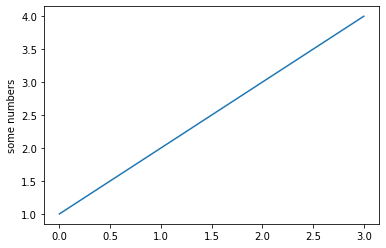

In [261]:
import matplotlib.pyplot as plt
plt.plot([1,2,3,4])
plt.ylabel("some numbers")
plt.show()